In [95]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import os
from pprint import pprint

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    f1_score,
    precision_score,
    recall_score,
)
from sklearn.model_selection import train_test_split
from tqdm import tqdm

In [96]:
RANDOM_STATE = 110

train_data = pd.read_csv("C:/Users/KimDongyoung/Desktop/git_LGaimers5/Lg_aimers5/data/train_data.csv")
test_data = pd.read_csv("C:/Users/KimDongyoung/Desktop/git_LGaimers5/Lg_aimers5/data/test_data.csv")

기본 전처리 할 것들

In [97]:
# 'Workorder_AutoClave' 열에서 '-' 다음 숫자 값 추출 및 '000' 제거
train_data['Workorder'] = train_data['Workorder'].str.replace(r'-(\d+)', lambda x: '-' + x.group(1).lstrip('0'), regex=True)
test_data['Workorder'] = test_data['Workorder'].str.replace(r'-(\d+)', lambda x: '-' + x.group(1).lstrip('0'), regex=True)

In [98]:
# Dispenser_num 값에 따라 새로운 변수 생성
train_data['Dispenser_1'] = train_data['Dispenser_num'].apply(lambda x: 1 if x == '#1' else 0)
train_data['Dispenser_2'] = train_data['Dispenser_num'].apply(lambda x: 1 if x == '#2' else 0)

test_data['Dispenser_1'] = test_data['Dispenser_num'].apply(lambda x: 1 if x == '#1' else 0)
test_data['Dispenser_2'] = test_data['Dispenser_num'].apply(lambda x: 1 if x == '#2' else 0)

# 불필요한 변수 제거
train_data.drop(['Dispenser_num'], axis=1, inplace=True)
test_data.drop(['Dispenser_num'], axis=1, inplace=True)

In [99]:
# WorkMode Collect Result_Dam의 이름을 WorkMode Collect Result로 변경
train_data = train_data.rename(columns={'WorkMode Collect Result_Dam': 'WorkMode Collect Result'})
test_data = test_data.rename(columns={'WorkMode Collect Result_Dam': 'WorkMode Collect Result'})

# WorkMode Collect Result_Fill1, WorkMode Collect Result_Fill2 열 드롭
train_data = train_data.drop(columns=['WorkMode Collect Result_Fill1', 'WorkMode Collect Result_Fill2'])
test_data = test_data.drop(columns=['WorkMode Collect Result_Fill1', 'WorkMode Collect Result_Fill2'])

# WorkMode Collect Result 열의 값이 7인 행을 1로 변경
train_data['WorkMode Collect Result'] = train_data['WorkMode Collect Result'].replace(7, 1)
test_data['WorkMode Collect Result'] = test_data['WorkMode Collect Result'].replace(7, 1)

# WorkMode Collect Result 열의 결측값을 0으로 채움
train_data['WorkMode Collect Result'] = train_data['WorkMode Collect Result'].fillna(0)
test_data['WorkMode Collect Result'] = test_data['WorkMode Collect Result'].fillna(0)

In [100]:
train_data

,Model.Suffix,Workorder,CURE END POSITION X Collect Result_Dam,CURE END POSITION Z Collect Result_Dam,CURE END POSITION Θ Collect Result_Dam,CURE SPEED Collect Result_Dam,CURE START POSITION X Collect Result_Dam,CURE START POSITION Θ Collect Result_Dam,DISCHARGED SPEED OF RESIN Collect Result_Dam,DISCHARGED TIME OF RESIN(Stage1) Collect Result_Dam,...,HEAD NORMAL COORDINATE Z AXIS(Stage2) Collect Result_Fill2,HEAD NORMAL COORDINATE Z AXIS(Stage3) Collect Result_Fill2,Head Purge Position Z Collect Result_Fill2,Machine Tact time Collect Result_Fill2,PalletID Collect Result_Fill2,Production Qty Collect Result_Fill2,Receip No Collect Result_Fill2,target,Dispenser_1,Dispenser_2
0,AJX75334505,4F1XA938-1,240,2.5,-90,100,1030,-90,16,14.9,...,243.7,243.7,114.612,19.9,7,127,1,Normal,1,0
1,AJX75334505,3KPM0016-2,240,2.5,-90,70,1030,-90,10,21.3,...,243.7,243.7,85.000,19.6,7,185,1,Normal,1,0
2,AJX75334501,4E1X9167-1,1000,12.5,90,85,280,90,16,14.7,...,243.5,243.5,114.612,19.8,10,73,1,Normal,0,1
3,AJX75334501,3K1X0057-1,1000,12.5,90,70,280,90,10,21.3,...,243.5,243.5,85.000,19.9,12,268,1,Normal,0,1
4,AJX75334501,3HPM0007-1,240,2.5,-90,70,1030,-90,10,9.7,...,243.7,243.7,85.000,19.7,8,121,1,Normal,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40501,AJX75334501,3J1XF434-2,240,2.5,-90,70,1030,-90,10,17.0,...,243.7,243.7,85.000,19.2,1,318,1,Normal,1,0
40502,AJX75334501,4E1XC796-1,1000,12.5,90,100,280,90,16,14.9,...,243.5,243.5,114.612,20.5,14,197,1,Normal,0,1
40503,AJX75334501,4C1XD438-1,240,2.5,-90,100,1030,-90,16,14.2,...,243.7,243.7,85.000,19.7,1,27,1,Normal,1,0
40504,AJX75334501,3I1XA258-1,1000,12.5,90,70,280,90,10,9.7,...,243.5,243.5,85.000,20.1,13,117,1,Normal,0,1


In [101]:
# 세 변수의 값이 동일하면 해당 값을 가져가고, 하나라도 일치하지 않으면 0의 값을 가지는 파생 변수 생성 함수
def create_receip_no_collect_result(df):
    df['Receip_No_Collect_Result'] = df.apply(
        lambda row: row['Receip No Collect Result_Dam'] 
                    if (row['Receip No Collect Result_Dam'] == row['Receip No Collect Result_Fill1'] == row['Receip No Collect Result_Fill2']) 
                    else 0, 
        axis=1
    )

# 함수 적용
create_receip_no_collect_result(train_data)
create_receip_no_collect_result(test_data)

# 제거할 변수 목록
columns_to_drop = [
    'Receip No Collect Result_Dam',
    'Receip No Collect Result_Fill1',
    'Receip No Collect Result_Fill2'
]

# 변수 제거
train_data.drop(columns=columns_to_drop, inplace=True)
test_data.drop(columns=columns_to_drop, inplace=True)

In [102]:
# 세 변수의 값이 동일하면 해당 값을 가져가고, 하나라도 일치하지 않으면 0의 값을 가지는 파생 변수 생성 함수
def create_palletid_collect_result(df):
    df['PalletID_Collect_Result'] = df.apply(
        lambda row: row['PalletID Collect Result_Dam'] 
                    if (row['PalletID Collect Result_Dam'] == row['PalletID Collect Result_Fill1'] == row['PalletID Collect Result_Fill2']) 
                    else 0, 
        axis=1
    )

# 함수 적용
create_palletid_collect_result(train_data)
create_palletid_collect_result(test_data)

In [103]:
# 제거할 변수 목록
columns_to_drop = [
    'PalletID Collect Result_Dam',
    'PalletID Collect Result_Fill1',
    'PalletID Collect Result_Fill2'
]

# 변수 제거
train_data.drop(columns=columns_to_drop, inplace=True)
test_data.drop(columns=columns_to_drop, inplace=True)

In [104]:
# 세 변수의 값이 동일하면 해당 값을 가져가고, 하나라도 일치하지 않으면 0의 값을 가지는 파생 변수 생성 함수
def create_palletid_collect_result(df):
    df['Production_Qty_Collect_Result'] = df.apply(
        lambda row: row['Production Qty Collect Result_Dam'] 
                    if (row['Production Qty Collect Result_Dam'] == row['Production Qty Collect Result_Fill1'] == row['Production Qty Collect Result_Fill2']) 
                    else 0, 
        axis=1
    )

# 함수 적용
create_palletid_collect_result(train_data)
create_palletid_collect_result(test_data) 

In [105]:

# 제거할 변수 목록
columns_to_drop = [
    'Production Qty Collect Result_Dam',
    'Production Qty Collect Result_Fill1',
    'Production Qty Collect Result_Fill2'
]

# 변수 제거
train_data.drop(columns=columns_to_drop, inplace=True)
test_data.drop(columns=columns_to_drop, inplace=True)

In [106]:
# "Chamber Temp. Judge Value_AutoClave" 변수의 값을 기준으로 파생 변수 생성 함수
def create_judge_value_binary(df):
    df['Chamber_Temp_OKNG_AutoClave'] = df['Chamber Temp. Judge Value_AutoClave'].apply(
        lambda x: 1 if x == 'OK' else 0
    )

# 함수 적용
create_judge_value_binary(train_data)
create_judge_value_binary(test_data)

In [107]:
# 'Judge Value'를 포함하는 열 이름 필터링
Process_Desc_col = train_data.filter(like='Judge').columns

print("\n Judge Value 포함 변수>")
for col in Process_Desc_col:
    print(col)


 Judge Value 포함 변수>
HEAD NORMAL COORDINATE X AXIS(Stage1) Judge Value_Dam
Chamber Temp. Judge Value_AutoClave
GMES_ORIGIN_INSP_JUDGE_CODE Judge Value_AutoClave
HEAD NORMAL COORDINATE X AXIS(Stage1) Judge Value_Fill1
HEAD NORMAL COORDINATE X AXIS(Stage1) Judge Value_Fill2


In [108]:
# 5개의 변수 목록
judge_value_columns = [
    'HEAD NORMAL COORDINATE X AXIS(Stage1) Judge Value_Dam'
    , 'GMES_ORIGIN_INSP_JUDGE_CODE Judge Value_AutoClave'
    , 'HEAD NORMAL COORDINATE X AXIS(Stage1) Judge Value_Fill1'
    , 'HEAD NORMAL COORDINATE X AXIS(Stage1) Judge Value_Fill2'
    , 'GMES_ORIGIN_INSP_JUDGE_CODE Collect Result_AutoClave'
]

# 파생 변수 생성 함수
def create_judge_value_feature(df):
    df['Judge_Value_OK'] = df[judge_value_columns].apply(
        lambda row: 1 if any(row == 'OK') else 0, 
        axis=1
    )

# 함수 적용
create_judge_value_feature(train_data)
create_judge_value_feature(test_data)  

In [109]:
# 제거할 변수 목록
columns_to_drop = [
    'Chamber Temp. Judge Value_AutoClave'
    , 'HEAD NORMAL COORDINATE X AXIS(Stage1) Judge Value_Dam'
    , 'GMES_ORIGIN_INSP_JUDGE_CODE Judge Value_AutoClave'
    , 'HEAD NORMAL COORDINATE X AXIS(Stage1) Judge Value_Fill1'
    , 'HEAD NORMAL COORDINATE X AXIS(Stage1) Judge Value_Fill2'
    , 'GMES_ORIGIN_INSP_JUDGE_CODE Collect Result_AutoClave'
]

# 변수 제거
train_data.drop(columns=columns_to_drop, inplace=True)
test_data.drop(columns=columns_to_drop, inplace=True)

In [110]:
# 변수명 변경
train_data = train_data.rename(columns={'1st Pressure 1st Pressure Unit Time_AutoClave': '1st Pressure Unit Time_AutoClave'})
test_data = test_data.rename(columns={'1st Pressure 1st Pressure Unit Time_AutoClave': '1st Pressure Unit Time_AutoClave'})

### 반복적으로 쓰는 툴 함수화

In [111]:
def plot_box(df, col_name):
    """
    주어진 데이터프레임과 열 이름에 대해 박스 플롯을 그리는 함수.

    Parameters:
    dataframe (pd.DataFrame): 데이터프레임
    column_name (str): 열 이름
    """
    plt.figure(figsize=(7, 4))
    plt.boxplot(df[col_name], vert=False)
    plt.xlabel(col_name)
    plt.title(f'Box Plot of {col_name}')
    plt.show()

In [112]:
def value_counts_ratio(df, col_name, target_name='target'):
    """
    주어진 데이터프레임의 특정 열에 대해 각 값마다 타겟 변수의 비율과 갯수, 총 갯수를 출력하는 함수.

    Parameters:
    df (pd.DataFrame): 데이터프레임
    col_name (str): 열 이름
    target_name (str): 타겟 변수 이름
    """
    # 각 값마다 타겟 변수의 비율 계산
    value_counts = df.groupby(col_name)[target_name].value_counts(normalize=True).unstack().fillna(0)
    
    # 각 값마다 타겟 변수의 갯수 계산
    counts = df.groupby(col_name)[target_name].value_counts().unstack().fillna(0)
    
    # 각 값마다 총 갯수 계산
    total_counts = df[col_name].value_counts().rename('Total_Count')
    
    # 비율과 갯수를 합침
    result = value_counts.join(counts, lsuffix='_ratio', rsuffix='_count')
    
    # 총 갯수를 합침
    result = result.join(total_counts, on=col_name)
    
    # 출력 형식 조정
    result.index.name = 'variable'
    print(f"\n{col_name}별 {target_name} 비율 및 갯수\n")
    print(result.rename(columns=lambda x: x.split('_')[0]))

In [113]:
def summarize_group(df, group_by_columns):
    # 데이터프레임을 그룹화
    grouped_df = df.groupby(group_by_columns)
    
    # 결과를 저장할 리스트 초기화
    results = []
    
    # 그룹화된 데이터프레임의 내용을 확인하는 코드
    for name, group in grouped_df:
        # 그룹의 갯수 계산
        group_count = group.shape[0]
        
        # 'target' 변수의 'AdNormal' 비율과 갯수 계산
        adnormal_count = group['target'].value_counts().get('AbNormal', 0)
        adnormal_ratio = adnormal_count / group_count
        
        # 결과 리스트에 추가
        results.append([name, adnormal_count, adnormal_ratio, group_count])
    
    # 결과 리스트를 데이터프레임으로 변환
    results_df = pd.DataFrame(results, columns=['group', "'AdNormal' count", 'ratio', 'Total'])
    
    # 그룹화된 변수들의 이름을 제목행으로 출력
    print(f"Grouped by: {', '.join(group_by_columns)}")
    print()
    # 데이터프레임 출력
    print(results_df)

# 예시코드
# summarize_grouped_data(train_data, ['1st Pressure Collect Result_AutoClave', '1st Pressure Unit Time_AutoClave'])

In [114]:
def plot_ratio(df, group_by_column, target_column='target', abnormal_value='AbNormal'):
    # 데이터프레임을 그룹화
    grouped_df = df.groupby(group_by_column)
    
    # 결과를 저장할 리스트 초기화
    results = []
    
    # 그룹화된 데이터프레임의 내용을 확인하는 코드
    for name, group in grouped_df:
        # 그룹의 갯수 계산
        group_count = group.shape[0]
        
        # 'target' 변수의 'AbNormal' 비율과 갯수 계산
        abnormal_count = group[target_column].value_counts().get(abnormal_value, 0)
        abnormal_ratio = abnormal_count / group_count
        
        # 결과 리스트에 추가
        results.append([name, abnormal_count, abnormal_ratio, group_count])
    
    # 결과 리스트를 데이터프레임으로 변환
    results_df = pd.DataFrame(results, columns=['group', f"'{abnormal_value}' count", 'ratio', 'Total'])
    
    # 그래프 크기 설정
    plt.figure(figsize=(10, 5))
    
    # 막대 그래프 생성
    ax = results_df.plot(kind='bar', x='group', y='ratio', legend=False)
    
    # 각 막대 위에 AbNormal 갯수와 총 갯수 표시
    for i, (abnormal_count, total) in enumerate(zip(results_df[f"'{abnormal_value}' count"], results_df['Total'])):
        ax.text(i, results_df['ratio'][i], f'{abnormal_count} ({total})', ha='center', va='bottom', fontsize=8)
    
     # 그래프 제목 및 축 레이블 설정
    ax.set_title(f'{abnormal_value} Ratio by {group_by_column}')
    ax.set_xlabel(group_by_column)
    ax.set_ylabel(f'{abnormal_value} Ratio')
   
    # 그래프 출력
    plt.show()

In [115]:
def plot_ratio_boxplot(data, time_ratio_column, target_column='target'):
    # 그래프 스타일 설정
    sns.set(style="whitegrid")

    # 그래프 그리기
    plt.figure(figsize=(10, 6))
    sns.boxplot(x=time_ratio_column, y=target_column, data=data)

    # 그래프 제목 및 레이블 설정
    plt.title(f'{time_ratio_column} vs {target_column}')
    plt.xlabel(time_ratio_column)
    plt.ylabel(target_column)

    # 그래프 출력
    plt.show()

# 함수 호출 예제
#plot_time_ratio_vs_target(train_data, 'time_ratio_Dam')

Cure_Dam

In [116]:
summarize_group(train_data, [
'Dispenser_1'
, 'Dispenser_2'
# 'CURE END POSITION X Collect Result_Dam'
, 'CURE END POSITION Θ Collect Result_Dam'
# , 'CURE SPEED Collect Result_Dam'
# , 'CURE START POSITION X Collect Result_Dam'
, 'CURE START POSITION Θ Collect Result_Dam'
# , 'CURE END POSITION X Collect Result_Fill2'
# , 'CURE END POSITION Z Collect Result_Fill2'
# , 'CURE SPEED Collect Result_Fill2'
# , 'CURE STANDBY POSITION Z Collect Result_Fill2'
# , 'CURE START POSITION X Collect Result_Fill2'
# , 'CURE START POSITION Z Collect Result_Fill2'
])

Grouped by: Dispenser_1, Dispenser_2, CURE END POSITION Θ Collect Result_Dam, CURE START POSITION Θ Collect Result_Dam

              group  'AdNormal' count     ratio  Total
0  (0, 0, -90, -90)                19  1.000000     19
1    (0, 0, 90, 90)                15  1.000000     15
2    (0, 1, 90, 90)               850  0.054977  15461
3  (1, 0, -90, -90)              1466  0.058614  25011


In [117]:
# 제거할 변수 목록
columns_to_drop = [
    'CURE END POSITION Θ Collect Result_Dam'
    , 'CURE START POSITION Θ Collect Result_Dam'
]

# 변수 제거
train_data.drop(columns=columns_to_drop, inplace=True)
test_data.drop(columns=columns_to_drop, inplace=True)

In [118]:
# 'CURE'를 포함하는 열 이름 필터링
Process_Desc_col = train_data.filter(like='CURE').columns

print("\n CURE 포함 변수>")
for col in Process_Desc_col:
    print(col)


 CURE 포함 변수>
CURE END POSITION X Collect Result_Dam
CURE END POSITION Z Collect Result_Dam
CURE SPEED Collect Result_Dam
CURE START POSITION X Collect Result_Dam
CURE END POSITION X Collect Result_Fill2
CURE END POSITION Z Collect Result_Fill2
CURE SPEED Collect Result_Fill2
CURE STANDBY POSITION Z Collect Result_Fill2
CURE START POSITION X Collect Result_Fill2
CURE START POSITION Z Collect Result_Fill2


In [119]:
summarize_group(train_data, [
'Dispenser_1'
, 'Dispenser_2'
, 'CURE END POSITION X Collect Result_Dam'
, 'CURE END POSITION Z Collect Result_Dam'
# , 'CURE SPEED Collect Result_Dam'
, 'CURE START POSITION X Collect Result_Dam'
# , 'CURE END POSITION X Collect Result_Fill2'
# , 'CURE END POSITION Z Collect Result_Fill2'
# , 'CURE SPEED Collect Result_Fill2'
# , 'CURE STANDBY POSITION Z Collect Result_Fill2'
# , 'CURE START POSITION X Collect Result_Fill2'
# , 'CURE START POSITION Z Collect Result_Fill2'
])

Grouped by: Dispenser_1, Dispenser_2, CURE END POSITION X Collect Result_Dam, CURE END POSITION Z Collect Result_Dam, CURE START POSITION X Collect Result_Dam

                     group  'AdNormal' count     ratio  Total
0   (0, 0, 240, 2.5, 1030)                19  1.000000     19
1  (0, 0, 1000, 12.5, 280)                15  1.000000     15
2  (0, 1, 1000, 12.5, 280)               850  0.054977  15461
3   (1, 0, 240, 2.5, 1030)              1466  0.058614  25011


좌표값을 통해 좌표간의 거리를 계산

In [120]:
# 시작 위치와 끝 위치 열 이름
start_x_col = 'CURE START POSITION X Collect Result_Dam'
start_z_col = 33.5
end_x_col = 'CURE END POSITION X Collect Result_Dam'
end_z_col = 'CURE END POSITION Z Collect Result_Dam'

# 시작 위치와 끝 위치 사이의 거리 계산
train_data['CURE_DISTANCE_Dam'] = np.sqrt(
    (train_data[end_x_col] - train_data[start_x_col]) ** 2 +
    (train_data[end_z_col] - start_z_col) ** 2
)

test_data['CURE_DISTANCE_Dam'] = np.sqrt(
    (train_data[end_x_col] - train_data[start_x_col]) ** 2 +
    (train_data[end_z_col] - start_z_col) ** 2
)

In [121]:
# 시작 위치와 끝 위치 열 이름
start_x_col = 'CURE START POSITION X Collect Result_Fill2'
start_z_col = 'CURE START POSITION Z Collect Result_Fill2'
end_x_col = 'CURE END POSITION X Collect Result_Fill2'
end_z_col = 'CURE END POSITION Z Collect Result_Fill2'

# 시작 위치와 끝 위치 사이의 거리 계산
train_data['CURE_DISTANCE_Fill2'] = np.sqrt(
    (train_data[end_x_col] - train_data[start_x_col]) ** 2 +
    (train_data[end_z_col] - train_data[start_z_col]) ** 2
)

test_data['CURE_DISTANCE_Fill2'] = np.sqrt(
    (train_data[end_x_col] - train_data[start_x_col]) ** 2 +
    (train_data[end_z_col] - train_data[start_z_col]) ** 2
)

In [122]:
# 제거할 변수 목록
columns_to_drop = [
    'CURE START POSITION X Collect Result_Dam'
    , 'CURE END POSITION X Collect Result_Dam'
    , 'CURE END POSITION Z Collect Result_Dam'

    , 'CURE START POSITION X Collect Result_Fill2'
    , 'CURE START POSITION Z Collect Result_Fill2'
    , 'CURE END POSITION X Collect Result_Fill2'
    , 'CURE END POSITION Z Collect Result_Fill2'
]

# 변수 제거
train_data.drop(columns=columns_to_drop, inplace=True)
test_data.drop(columns=columns_to_drop, inplace=True)

In [123]:
# 'CURE'를 포함하는 열 이름 필터링
Process_Desc_col = train_data.filter(like='CURE').columns

print("\n CURE 포함 변수>")
for col in Process_Desc_col:
    print(col)


 CURE 포함 변수>
CURE SPEED Collect Result_Dam
CURE SPEED Collect Result_Fill2
CURE STANDBY POSITION Z Collect Result_Fill2
CURE_DISTANCE_Dam
CURE_DISTANCE_Fill2


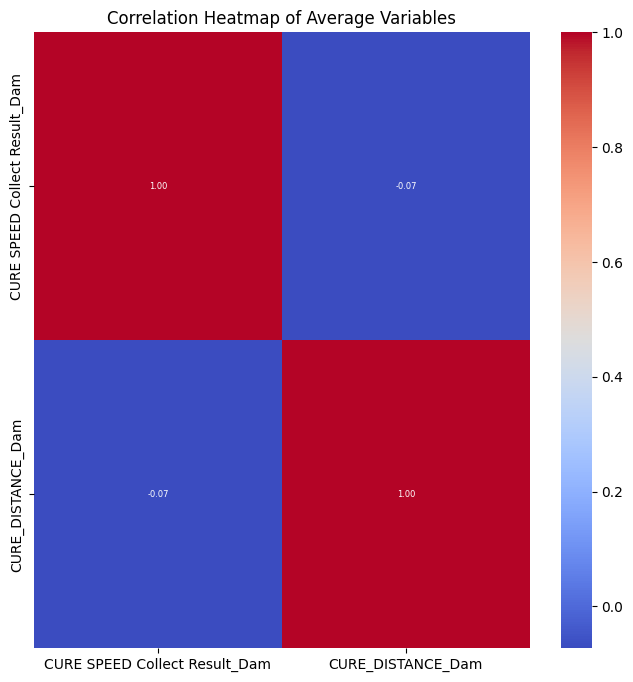

In [124]:
# 상관계수
variables = [
    'CURE SPEED Collect Result_Dam',
    'CURE_DISTANCE_Dam',
   
]

# Compute the correlation matrix
correlation_matrix = train_data[variables].corr()

# Set the size of the plot
plt.figure(figsize=(8, 8))

# Create a heatmap of the correlation matrix
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", annot_kws={"size": 6})

# Set the title of the heatmap
plt.title("Correlation Heatmap of Average Variables")

# Display the plot
plt.show()

In [125]:
summarize_group(train_data, [
'Dispenser_1'
, 'Dispenser_2'
, 'CURE SPEED Collect Result_Dam'
])

Grouped by: Dispenser_1, Dispenser_2, CURE SPEED Collect Result_Dam

          group  'AdNormal' count     ratio  Total
0    (0, 0, 70)                27  1.000000     27
1    (0, 0, 85)                 4  1.000000      4
2   (0, 0, 100)                 2  1.000000      2
3   (0, 0, 105)                 1  1.000000      1
4    (0, 1, 70)               697  0.055269  12611
5    (0, 1, 85)                72  0.071076   1013
6    (0, 1, 95)                 3  0.039474     76
7   (0, 1, 100)                39  0.038576   1011
8   (0, 1, 105)                39  0.052000    750
9    (1, 0, 70)              1328  0.060943  21791
10   (1, 0, 85)                51  0.042642   1196
11   (1, 0, 95)                 1  0.012048     83
12  (1, 0, 100)                52  0.049430   1052
13  (1, 0, 105)                34  0.038245    889


In [126]:
summarize_group(train_data, [
 'Dispenser_1'
 , 'Dispenser_2'
# , 'CURE SPEED Collect Result_Dam'
# , 'CURE SPEED Collect Result_Fill2'
 ,'CURE STANDBY POSITION Z Collect Result_Fill2'
# , 'CURE_DISTANCE_Dam'
# , 'CURE_DISTANCE_Fill2'
])

Grouped by: Dispenser_1, Dispenser_2, CURE STANDBY POSITION Z Collect Result_Fill2

        group  'AdNormal' count     ratio  Total
0  (0, 0, 33)                34  1.000000     34
1  (0, 1, 22)                 0  0.000000      5
2  (0, 1, 32)                23  0.070552    326
3  (0, 1, 33)               827  0.054660  15130
4  (1, 0, 22)                34  0.073276    464
5  (1, 0, 23)                22  0.107843    204
6  (1, 0, 32)               398  0.086957   4577
7  (1, 0, 33)              1012  0.051199  19766


In [127]:
# 제거할 변수 목록
columns_to_drop = ['CURE STANDBY POSITION Z Collect Result_Fill2']

# 변수 제거
train_data.drop(columns=columns_to_drop, inplace=True)
test_data.drop(columns=columns_to_drop, inplace=True)

In [128]:
# 'CURE'를 포함하는 열 이름 필터링
Process_Desc_col = train_data.filter(like='CURE').columns

print("\n CURE 포함 변수>")
for col in Process_Desc_col:
    print(col)


 CURE 포함 변수>
CURE SPEED Collect Result_Dam
CURE SPEED Collect Result_Fill2
CURE_DISTANCE_Dam
CURE_DISTANCE_Fill2


In [129]:
summarize_group(train_data, [
'Dispenser_1'
, 'Dispenser_2'
# , 'CURE SPEED Collect Result_Dam'
# , 'CURE SPEED Collect Result_Fill2'
, 'CURE_DISTANCE_Dam'
, 'CURE_DISTANCE_Fill2'
])

Grouped by: Dispenser_1, Dispenser_2, CURE_DISTANCE_Dam, CURE_DISTANCE_Fill2

                                          group  'AdNormal' count     ratio  \
0              (0, 0, 720.3061848963953, 780.0)                15  1.000000   
1               (0, 0, 790.607993888248, 780.0)                19  1.000000   
2              (0, 1, 720.3061848963953, 780.0)               827  0.054645   
3  (0, 1, 720.3061848963953, 780.0006410253776)                23  0.070552   
4  (0, 1, 720.3061848963953, 780.0775602464155)                 0  0.000000   
5               (1, 0, 790.607993888248, 780.0)              1129  0.054418   
6   (1, 0, 790.607993888248, 780.0006410253776)               286  0.077591   
7   (1, 0, 790.607993888248, 780.0640999302557)                51  0.088235   

   Total  
0     15  
1     19  
2  15134  
3    326  
4      1  
5  20747  
6   3686  
7    578  


In [130]:
# 거리 / 속도 -> 시간 파생 변수 생성
train_data['CURE_Time_Dam']  = train_data['CURE_DISTANCE_Dam'] / train_data['CURE SPEED Collect Result_Dam']
test_data['CURE_Time_Dam']  = test_data['CURE_DISTANCE_Dam'] / test_data['CURE SPEED Collect Result_Dam']

train_data['CURE_Time_Fill2']  = train_data['CURE_DISTANCE_Fill2'] / train_data['CURE SPEED Collect Result_Fill2']
test_data['CURE_Time_Fill2']  = test_data['CURE_DISTANCE_Fill2'] / test_data['CURE SPEED Collect Result_Fill2']

In [131]:
# 'CURE'를 포함하는 열 이름 필터링
Process_Desc_col = train_data.filter(like='CURE').columns

print("\n CURE 포함 변수>")
for col in Process_Desc_col:
    print(col)


 CURE 포함 변수>
CURE SPEED Collect Result_Dam
CURE SPEED Collect Result_Fill2
CURE_DISTANCE_Dam
CURE_DISTANCE_Fill2
CURE_Time_Dam
CURE_Time_Fill2


In [132]:
summarize_group(train_data, [
'Dispenser_1'
, 'Dispenser_2'
# , 'CURE SPEED Collect Result_Dam'
# , 'CURE SPEED Collect Result_Fill2'
, 'CURE_Time_Dam'
, 'CURE_Time_Fill2'
])

Grouped by: Dispenser_1, Dispenser_2, CURE_Time_Dam, CURE_Time_Fill2

                                             group  'AdNormal' count  \
0                 (0, 0, 6.860058903775193, 16.25)                 1   
1                 (0, 0, 7.203061848963952, 16.25)                 1   
2                  (0, 0, 7.906079938882479, 15.6)                 1   
3    (0, 0, 8.474190410545827, 17.333333333333332)                 3   
4    (0, 0, 9.301270516332329, 17.333333333333332)                 1   
5                 (0, 0, 10.290088355662789, 15.6)                 9   
6                 (0, 0, 10.290088355662789, 19.5)                 1   
7                 (0, 0, 11.294399912689256, 15.6)                13   
8   (0, 0, 11.294399912689256, 17.333333333333332)                 3   
9                 (0, 0, 11.294399912689256, 19.5)                 1   
10                 (0, 1, 6.860058903775193, 15.6)                 6   
11                (0, 1, 6.860058903775193, 16.25)                

In [133]:
# 제거할 변수 목록
columns_to_drop = [
    'CURE_DISTANCE_Dam'
    , 'CURE SPEED Collect Result_Dam'
    , 'CURE_DISTANCE_Fill2'
    , 'CURE SPEED Collect Result_Fill2'
]

# 변수 제거
train_data.drop(columns=columns_to_drop, inplace=True)
test_data.drop(columns=columns_to_drop, inplace=True)

In [134]:
# 'CURE'를 포함하는 열 이름 필터링
Process_Desc_col = train_data.filter(like='CURE').columns

print("\n CURE 포함 변수>")
for col in Process_Desc_col:
    print(col)


 CURE 포함 변수>
CURE_Time_Dam
CURE_Time_Fill2


HEAD Normal Coordinate

In [135]:
# 'HEAD NORMAL COORDINATE'를 포함하는 열 이름 필터링
Process_Desc_col = train_data.filter(like='HEAD NORMAL COORDINATE').columns

print("\n HEAD NORMAL COORDINATE 포함 변수>")
for col in Process_Desc_col:
    print(col)


 HEAD NORMAL COORDINATE 포함 변수>
HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Dam
HEAD NORMAL COORDINATE X AXIS(Stage2) Collect Result_Dam
HEAD NORMAL COORDINATE X AXIS(Stage3) Collect Result_Dam
HEAD NORMAL COORDINATE Y AXIS(Stage1) Collect Result_Dam
HEAD NORMAL COORDINATE Y AXIS(Stage2) Collect Result_Dam
HEAD NORMAL COORDINATE Y AXIS(Stage3) Collect Result_Dam
HEAD NORMAL COORDINATE Z AXIS(Stage1) Collect Result_Dam
HEAD NORMAL COORDINATE Z AXIS(Stage2) Collect Result_Dam
HEAD NORMAL COORDINATE Z AXIS(Stage3) Collect Result_Dam
HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Fill1
HEAD NORMAL COORDINATE X AXIS(Stage2) Collect Result_Fill1
HEAD NORMAL COORDINATE X AXIS(Stage3) Collect Result_Fill1
HEAD NORMAL COORDINATE Y AXIS(Stage1) Collect Result_Fill1
HEAD NORMAL COORDINATE Y AXIS(Stage2) Collect Result_Fill1
HEAD NORMAL COORDINATE Y AXIS(Stage3) Collect Result_Fill1
HEAD NORMAL COORDINATE Z AXIS(Stage1) Collect Result_Fill1
HEAD NORMAL COORDINATE Z AXIS(Stage2) Coll

In [136]:
# 각 스테이지의 좌표 열 정의
stage1_cols = ['HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Dam',
               'HEAD NORMAL COORDINATE Y AXIS(Stage1) Collect Result_Dam',
               'HEAD NORMAL COORDINATE Z AXIS(Stage1) Collect Result_Dam']

stage2_cols = ['HEAD NORMAL COORDINATE X AXIS(Stage2) Collect Result_Dam',
               'HEAD NORMAL COORDINATE Y AXIS(Stage2) Collect Result_Dam',
               'HEAD NORMAL COORDINATE Z AXIS(Stage2) Collect Result_Dam']

stage3_cols = ['HEAD NORMAL COORDINATE X AXIS(Stage3) Collect Result_Dam',
               'HEAD NORMAL COORDINATE Y AXIS(Stage3) Collect Result_Dam',
               'HEAD NORMAL COORDINATE Z AXIS(Stage3) Collect Result_Dam']

# 거리 계산 함수
def calculate_distances(data):
    data['HEAD NORMAL DISTANCE_STAGE1_STAGE2_Dam'] = np.sqrt(
        (data[stage2_cols[0]] - data[stage1_cols[0]]) ** 2 +
        (data[stage2_cols[1]] - data[stage1_cols[1]]) ** 2 +
        (data[stage2_cols[2]] - data[stage1_cols[2]]) ** 2
    )

    data['HEAD NORMAL DISTANCE_STAGE2_STAGE3_Dam'] = np.sqrt(
        (data[stage3_cols[0]] - data[stage2_cols[0]]) ** 2 +
        (data[stage3_cols[1]] - data[stage2_cols[1]]) ** 2 +
        (data[stage3_cols[2]] - data[stage2_cols[2]]) ** 2
    )

    data['HEAD NORMAL DISTANCE_STAGE1_STAGE3_Dam'] = np.sqrt(
        (data[stage3_cols[0]] - data[stage1_cols[0]]) ** 2 +
        (data[stage3_cols[1]] - data[stage1_cols[1]]) ** 2 +
        (data[stage3_cols[2]] - data[stage1_cols[2]]) ** 2
    )

    return data

# train_data에 적용
train_data = calculate_distances(train_data)

# test_data에 적용
test_data = calculate_distances(test_data)

In [137]:
# 필요한 열 이름
stage1_stage2_col = 'HEAD NORMAL DISTANCE_STAGE1_STAGE2_Dam'
stage2_stage3_col = 'HEAD NORMAL DISTANCE_STAGE2_STAGE3_Dam'
stage1_stage3_col = 'HEAD NORMAL DISTANCE_STAGE1_STAGE3_Dam'

# 삼각형의 넓이와 높이를 계산하는 함수
def calculate_triangle_features(data):
    a = data[stage1_stage2_col]
    b = data[stage2_stage3_col]
    c = data[stage1_stage3_col]

    # 헤론의 공식에 따른 삼각형의 넓이 계산
    s = (a + b + c) / 2
    area = np.sqrt(s * (s - a) * (s - b) * (s - c))

    # 높이 계산 (밑변을 c로 가정)
    height = (2 * area) / c

    # 결과를 새로운 열에 저장
    data['HEAD NORMAL DISTANCE_TRIANGLE_area_Dam'] = area
    data['HEAD NORMAL DISTANCE_TRIANGLE_height_Dam'] = height

    return data

# train_data에 적용
train_data = calculate_triangle_features(train_data)

# test_data에 적용
test_data = calculate_triangle_features(test_data)

In [138]:
# 제거할 변수 목록
columns_to_drop = [
    'HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Dam'
    , 'HEAD NORMAL COORDINATE Y AXIS(Stage1) Collect Result_Dam'
    , 'HEAD NORMAL COORDINATE Z AXIS(Stage1) Collect Result_Dam'

    , 'HEAD NORMAL COORDINATE X AXIS(Stage2) Collect Result_Dam'
    , 'HEAD NORMAL COORDINATE Y AXIS(Stage2) Collect Result_Dam'
    , 'HEAD NORMAL COORDINATE Z AXIS(Stage2) Collect Result_Dam'

    , 'HEAD NORMAL COORDINATE X AXIS(Stage3) Collect Result_Dam'
    , 'HEAD NORMAL COORDINATE Y AXIS(Stage3) Collect Result_Dam'
    , 'HEAD NORMAL COORDINATE Z AXIS(Stage3) Collect Result_Dam'
]

# 변수 제거
train_data.drop(columns=columns_to_drop, inplace=True)
test_data.drop(columns=columns_to_drop, inplace=True)

In [139]:
# 각 스테이지의 좌표 열 정의
stage1_cols = ['HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Fill1',
               'HEAD NORMAL COORDINATE Y AXIS(Stage1) Collect Result_Fill1',
               'HEAD NORMAL COORDINATE Z AXIS(Stage1) Collect Result_Fill1']

stage2_cols = ['HEAD NORMAL COORDINATE X AXIS(Stage2) Collect Result_Fill1',
               'HEAD NORMAL COORDINATE Y AXIS(Stage2) Collect Result_Fill1',
               'HEAD NORMAL COORDINATE Z AXIS(Stage2) Collect Result_Fill1']

stage3_cols = ['HEAD NORMAL COORDINATE X AXIS(Stage3) Collect Result_Fill1',
               'HEAD NORMAL COORDINATE Y AXIS(Stage3) Collect Result_Fill1',
               'HEAD NORMAL COORDINATE Z AXIS(Stage3) Collect Result_Fill1']

# 거리 계산 함수
def calculate_distances(data):
    data['HEAD NORMAL DISTANCE_STAGE1_STAGE2_Fill1'] = np.sqrt(
        (data[stage2_cols[0]] - data[stage1_cols[0]]) ** 2 +
        (data[stage2_cols[1]] - data[stage1_cols[1]]) ** 2 +
        (data[stage2_cols[2]] - data[stage1_cols[2]]) ** 2
    )

    data['HEAD NORMAL DISTANCE_STAGE2_STAGE3_Fill1'] = np.sqrt(
        (data[stage3_cols[0]] - data[stage2_cols[0]]) ** 2 +
        (data[stage3_cols[1]] - data[stage2_cols[1]]) ** 2 +
        (data[stage3_cols[2]] - data[stage2_cols[2]]) ** 2
    )

    data['HEAD NORMAL DISTANCE_STAGE1_STAGE3_Fill1'] = np.sqrt(
        (data[stage3_cols[0]] - data[stage1_cols[0]]) ** 2 +
        (data[stage3_cols[1]] - data[stage1_cols[1]]) ** 2 +
        (data[stage3_cols[2]] - data[stage1_cols[2]]) ** 2
    )

    return data

# train_data에 적용
train_data = calculate_distances(train_data)

# test_data에 적용
test_data = calculate_distances(test_data)

In [140]:
# 필요한 열 이름
stage1_stage2_col = 'HEAD NORMAL DISTANCE_STAGE1_STAGE2_Fill1'
stage2_stage3_col = 'HEAD NORMAL DISTANCE_STAGE2_STAGE3_Fill1'
stage1_stage3_col = 'HEAD NORMAL DISTANCE_STAGE1_STAGE3_Fill1'

# 삼각형의 넓이와 높이를 계산하는 함수
def calculate_triangle_features(data):
    a = data[stage1_stage2_col]
    b = data[stage2_stage3_col]
    c = data[stage1_stage3_col]

    # 헤론의 공식에 따른 삼각형의 넓이 계산
    s = (a + b + c) / 2
    area = np.sqrt(s * (s - a) * (s - b) * (s - c))

    # 높이 계산 (밑변을 c로 가정)
    height = (2 * area) / c

    # 결과를 새로운 열에 저장
    data['HEAD NORMAL DISTANCE_TRIANGLE_area_Fill1'] = area
    data['HEAD NORMAL DISTANCE_TRIANGLE_height_Fill1'] = height

    return data

# train_data에 적용
train_data = calculate_triangle_features(train_data)

# test_data에 적용
test_data = calculate_triangle_features(test_data)

In [141]:
# 제거할 변수 목록
columns_to_drop = [
    'HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Fill1'
    , 'HEAD NORMAL COORDINATE Y AXIS(Stage1) Collect Result_Fill1'
    , 'HEAD NORMAL COORDINATE Z AXIS(Stage1) Collect Result_Fill1'

    , 'HEAD NORMAL COORDINATE X AXIS(Stage2) Collect Result_Fill1'
    , 'HEAD NORMAL COORDINATE Y AXIS(Stage2) Collect Result_Fill1'
    , 'HEAD NORMAL COORDINATE Z AXIS(Stage2) Collect Result_Fill1'

    , 'HEAD NORMAL COORDINATE X AXIS(Stage3) Collect Result_Fill1'
    , 'HEAD NORMAL COORDINATE Y AXIS(Stage3) Collect Result_Fill1'
    , 'HEAD NORMAL COORDINATE Z AXIS(Stage3) Collect Result_Fill1'
]

# 변수 제거
train_data.drop(columns=columns_to_drop, inplace=True)
test_data.drop(columns=columns_to_drop, inplace=True)

In [142]:
# 각 스테이지의 좌표 열 정의
stage1_cols = ['HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Fill2',
               'HEAD NORMAL COORDINATE Y AXIS(Stage1) Collect Result_Fill2',
               'HEAD NORMAL COORDINATE Z AXIS(Stage1) Collect Result_Fill2']

stage2_cols = ['HEAD NORMAL COORDINATE X AXIS(Stage2) Collect Result_Fill2',
               'HEAD NORMAL COORDINATE Y AXIS(Stage2) Collect Result_Fill2',
               'HEAD NORMAL COORDINATE Z AXIS(Stage2) Collect Result_Fill2']

stage3_cols = ['HEAD NORMAL COORDINATE X AXIS(Stage3) Collect Result_Fill2',
               'HEAD NORMAL COORDINATE Y AXIS(Stage3) Collect Result_Fill2',
               'HEAD NORMAL COORDINATE Z AXIS(Stage3) Collect Result_Fill2']

# 거리 계산 함수
def calculate_distances(data):
    data['HEAD NORMAL DISTANCE_STAGE1_STAGE2_Fill2'] = np.sqrt(
        (data[stage2_cols[0]] - data[stage1_cols[0]]) ** 2 +
        (data[stage2_cols[1]] - data[stage1_cols[1]]) ** 2 +
        (data[stage2_cols[2]] - data[stage1_cols[2]]) ** 2
    )

    data['HEAD NORMAL DISTANCE_STAGE2_STAGE3_Fill2'] = np.sqrt(
        (data[stage3_cols[0]] - data[stage2_cols[0]]) ** 2 +
        (data[stage3_cols[1]] - data[stage2_cols[1]]) ** 2 +
        (data[stage3_cols[2]] - data[stage2_cols[2]]) ** 2
    )

    data['HEAD NORMAL DISTANCE_STAGE1_STAGE3_Fill2'] = np.sqrt(
        (data[stage3_cols[0]] - data[stage1_cols[0]]) ** 2 +
        (data[stage3_cols[1]] - data[stage1_cols[1]]) ** 2 +
        (data[stage3_cols[2]] - data[stage1_cols[2]]) ** 2
    )

    return data

# train_data에 적용
train_data = calculate_distances(train_data)

# test_data에 적용
test_data = calculate_distances(test_data)

In [143]:
# 제거할 변수 목록
columns_to_drop = [
    'HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Fill2'
    , 'HEAD NORMAL COORDINATE Y AXIS(Stage1) Collect Result_Fill2'
    , 'HEAD NORMAL COORDINATE Z AXIS(Stage1) Collect Result_Fill2'

    , 'HEAD NORMAL COORDINATE X AXIS(Stage2) Collect Result_Fill2'
    , 'HEAD NORMAL COORDINATE Y AXIS(Stage2) Collect Result_Fill2'
    , 'HEAD NORMAL COORDINATE Z AXIS(Stage2) Collect Result_Fill2'

    , 'HEAD NORMAL COORDINATE X AXIS(Stage3) Collect Result_Fill2'
    , 'HEAD NORMAL COORDINATE Y AXIS(Stage3) Collect Result_Fill2'
    , 'HEAD NORMAL COORDINATE Z AXIS(Stage3) Collect Result_Fill2'
]

# 변수 제거
train_data.drop(columns=columns_to_drop, inplace=True)
test_data.drop(columns=columns_to_drop, inplace=True)

In [144]:
# 'HEAD NORMAL'를 포함하는 열 이름 필터링
Process_Desc_col = train_data.filter(like='HEAD NORMAL').columns

print("\n HEAD NORMAL 포함 변수>")
for col in Process_Desc_col:
    print(col)


 HEAD NORMAL 포함 변수>
HEAD NORMAL DISTANCE_STAGE1_STAGE2_Dam
HEAD NORMAL DISTANCE_STAGE2_STAGE3_Dam
HEAD NORMAL DISTANCE_STAGE1_STAGE3_Dam
HEAD NORMAL DISTANCE_TRIANGLE_area_Dam
HEAD NORMAL DISTANCE_TRIANGLE_height_Dam
HEAD NORMAL DISTANCE_STAGE1_STAGE2_Fill1
HEAD NORMAL DISTANCE_STAGE2_STAGE3_Fill1
HEAD NORMAL DISTANCE_STAGE1_STAGE3_Fill1
HEAD NORMAL DISTANCE_TRIANGLE_area_Fill1
HEAD NORMAL DISTANCE_TRIANGLE_height_Fill1
HEAD NORMAL DISTANCE_STAGE1_STAGE2_Fill2
HEAD NORMAL DISTANCE_STAGE2_STAGE3_Fill2
HEAD NORMAL DISTANCE_STAGE1_STAGE3_Fill2


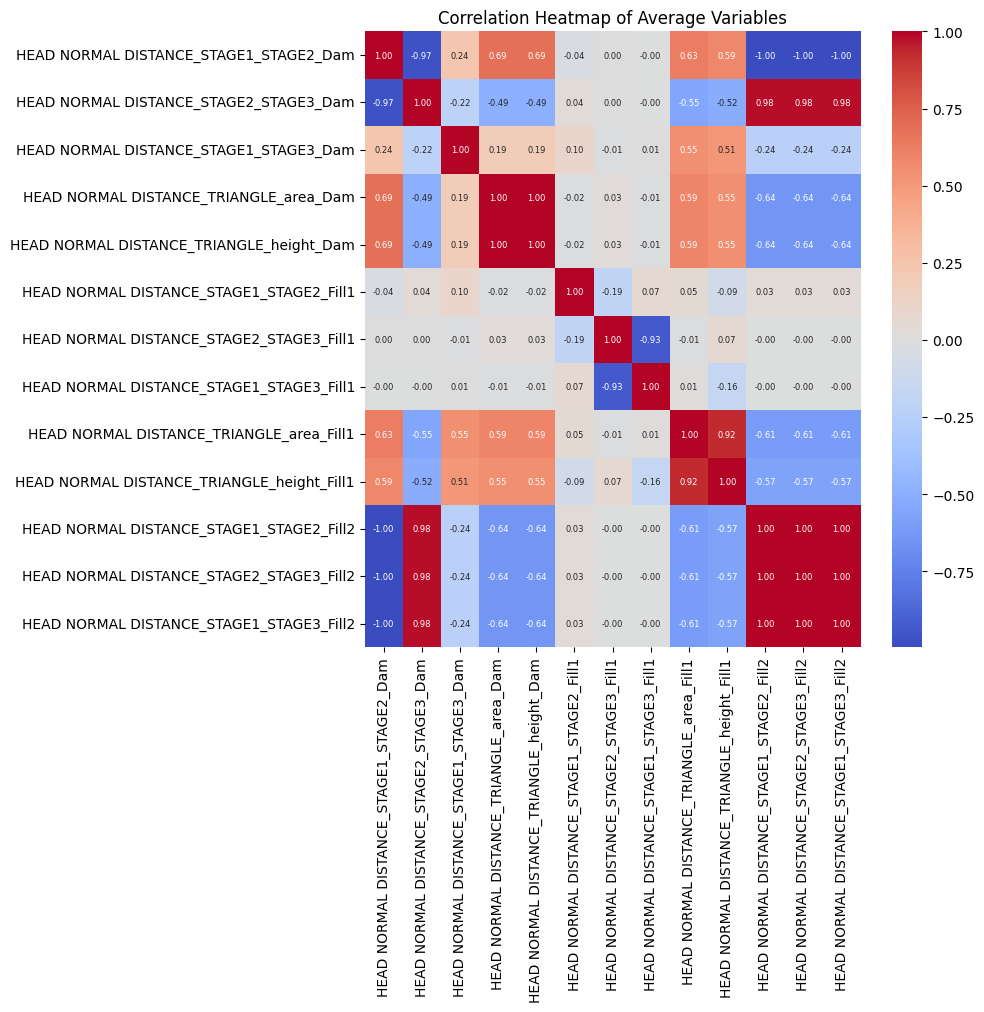

In [145]:
# 상관계수
variables = [
    'HEAD NORMAL DISTANCE_STAGE1_STAGE2_Dam',
'HEAD NORMAL DISTANCE_STAGE2_STAGE3_Dam',
'HEAD NORMAL DISTANCE_STAGE1_STAGE3_Dam',
'HEAD NORMAL DISTANCE_TRIANGLE_area_Dam',
'HEAD NORMAL DISTANCE_TRIANGLE_height_Dam',
'HEAD NORMAL DISTANCE_STAGE1_STAGE2_Fill1',
'HEAD NORMAL DISTANCE_STAGE2_STAGE3_Fill1',
'HEAD NORMAL DISTANCE_STAGE1_STAGE3_Fill1',
'HEAD NORMAL DISTANCE_TRIANGLE_area_Fill1',
'HEAD NORMAL DISTANCE_TRIANGLE_height_Fill1',
'HEAD NORMAL DISTANCE_STAGE1_STAGE2_Fill2',
'HEAD NORMAL DISTANCE_STAGE2_STAGE3_Fill2',
'HEAD NORMAL DISTANCE_STAGE1_STAGE3_Fill2',
   
]

# Compute the correlation matrix
correlation_matrix = train_data[variables].corr()

# Set the size of the plot
plt.figure(figsize=(8, 8))

# Create a heatmap of the correlation matrix
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", annot_kws={"size": 6})

# Set the title of the heatmap
plt.title("Correlation Heatmap of Average Variables")

# Display the plot
plt.show()

In [146]:
# 삭제할 열 이름 정의
columns_to_drop = [
    #'HEAD NORMAL DISTANCE_STAGE1_STAGE2_Dam'
     'HEAD NORMAL DISTANCE_STAGE2_STAGE3_Dam'
    # , 'HEAD NORMAL DISTANCE_STAGE1_STAGE3_Dam'

    #, 'HEAD NORMAL DISTANCE_STAGE1_STAGE2_Fill1'
    #, 'HEAD NORMAL DISTANCE_STAGE2_STAGE3_Fill1'
    # , 'HEAD NORMAL DISTANCE_STAGE1_STAGE3_Fill1'

    , 'HEAD NORMAL DISTANCE_STAGE1_STAGE2_Fill2'
    , 'HEAD NORMAL DISTANCE_STAGE2_STAGE3_Fill2'
    , 'HEAD NORMAL DISTANCE_STAGE1_STAGE3_Fill2'
    , 'HEAD NORMAL DISTANCE_TRIANGLE_height_Fill1'
]

# train_data에서 열 삭제
train_data = train_data.drop(columns=columns_to_drop)

# test_data에서 열 삭제
test_data = test_data.drop(columns=columns_to_drop)

In [147]:
# 'HEAD NORMAL'를 포함하는 열 이름 필터링
Process_Desc_col = train_data.filter(like='HEAD NORMAL').columns

print("\n HEAD NORMAL 포함 변수>")
for col in Process_Desc_col:
    print(col)


 HEAD NORMAL 포함 변수>
HEAD NORMAL DISTANCE_STAGE1_STAGE2_Dam
HEAD NORMAL DISTANCE_STAGE1_STAGE3_Dam
HEAD NORMAL DISTANCE_TRIANGLE_area_Dam
HEAD NORMAL DISTANCE_TRIANGLE_height_Dam
HEAD NORMAL DISTANCE_STAGE1_STAGE2_Fill1
HEAD NORMAL DISTANCE_STAGE2_STAGE3_Fill1
HEAD NORMAL DISTANCE_STAGE1_STAGE3_Fill1
HEAD NORMAL DISTANCE_TRIANGLE_area_Fill1


Resin

In [148]:

# 'RESIN' 또는 'Dispense Volume'을 포함하는 열 이름 필터링
Process_Desc_col = train_data.filter(regex='RESIN|Dispense Volume').columns

print("\n'RESIN' 또는 'Dispense Volume' 포함 변수>")
for col in Process_Desc_col:
    print(col)


'RESIN' 또는 'Dispense Volume' 포함 변수>
DISCHARGED SPEED OF RESIN Collect Result_Dam
DISCHARGED TIME OF RESIN(Stage1) Collect Result_Dam
DISCHARGED TIME OF RESIN(Stage2) Collect Result_Dam
DISCHARGED TIME OF RESIN(Stage3) Collect Result_Dam
Dispense Volume(Stage1) Collect Result_Dam
Dispense Volume(Stage2) Collect Result_Dam
Dispense Volume(Stage3) Collect Result_Dam
DISCHARGED SPEED OF RESIN Collect Result_Fill1
DISCHARGED TIME OF RESIN(Stage1) Collect Result_Fill1
DISCHARGED TIME OF RESIN(Stage2) Collect Result_Fill1
DISCHARGED TIME OF RESIN(Stage3) Collect Result_Fill1
Dispense Volume(Stage1) Collect Result_Fill1
Dispense Volume(Stage2) Collect Result_Fill1
Dispense Volume(Stage3) Collect Result_Fill1


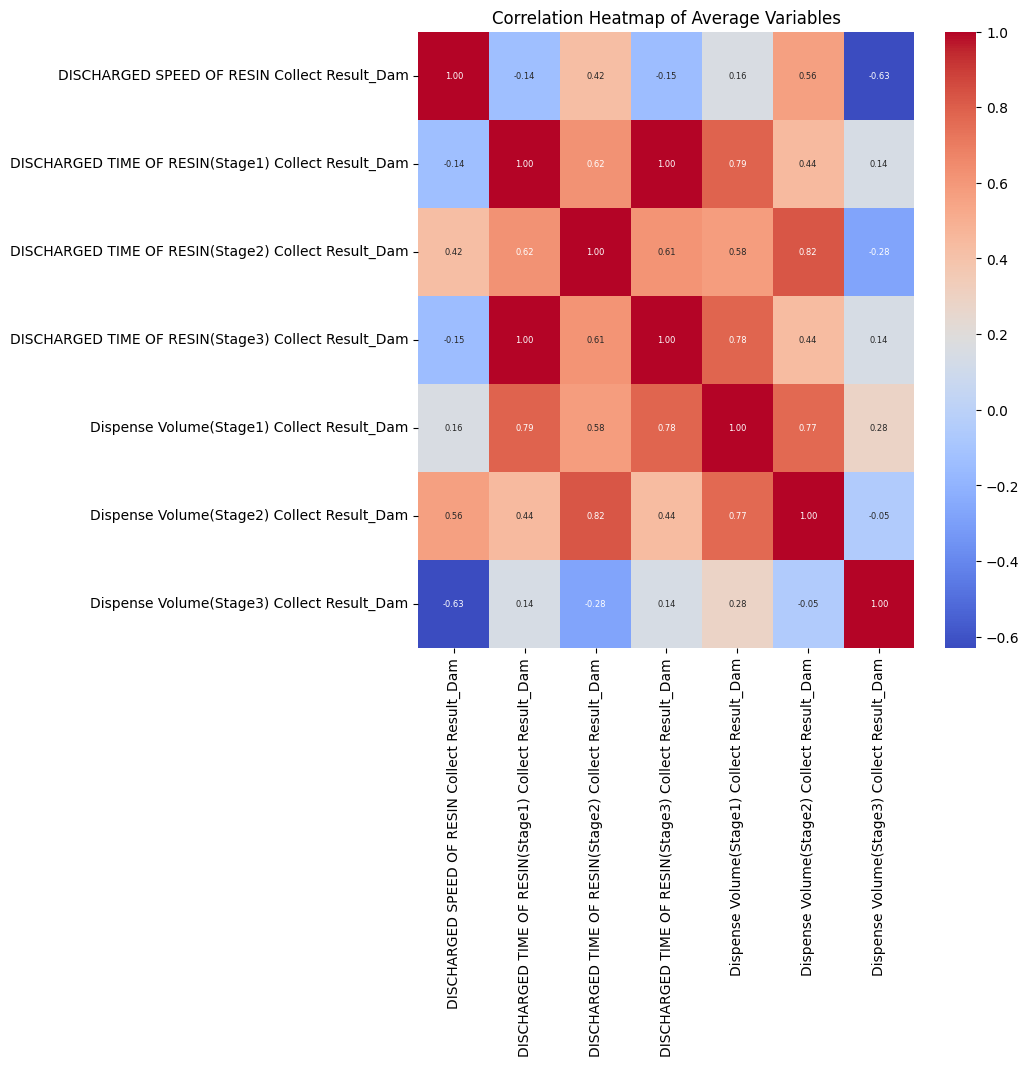

In [149]:
# 상관계수
variables = [
    'DISCHARGED SPEED OF RESIN Collect Result_Dam',
'DISCHARGED TIME OF RESIN(Stage1) Collect Result_Dam',
'DISCHARGED TIME OF RESIN(Stage2) Collect Result_Dam',
'DISCHARGED TIME OF RESIN(Stage3) Collect Result_Dam',
'Dispense Volume(Stage1) Collect Result_Dam',
'Dispense Volume(Stage2) Collect Result_Dam',
'Dispense Volume(Stage3) Collect Result_Dam',
   
]

# Compute the correlation matrix
correlation_matrix = train_data[variables].corr()

# Set the size of the plot
plt.figure(figsize=(8, 8))

# Create a heatmap of the correlation matrix
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", annot_kws={"size": 6})

# Set the title of the heatmap
plt.title("Correlation Heatmap of Average Variables")

# Display the plot
plt.show()

In [150]:
train_data['TIME_X_Volume_Stage1_Dam'] = train_data['DISCHARGED TIME OF RESIN(Stage1) Collect Result_Dam'] * train_data['Dispense Volume(Stage1) Collect Result_Dam']
train_data['TIME_X_Volume_Stage2_Dam'] = train_data['DISCHARGED TIME OF RESIN(Stage2) Collect Result_Dam'] * train_data['Dispense Volume(Stage2) Collect Result_Dam']
train_data['TIME_X_Volume_Stage3_Dam'] = train_data['DISCHARGED TIME OF RESIN(Stage3) Collect Result_Dam'] * train_data['Dispense Volume(Stage3) Collect Result_Dam']

test_data['TIME_X_Volume_Stage1_Dam'] = test_data['DISCHARGED TIME OF RESIN(Stage1) Collect Result_Dam'] * test_data['Dispense Volume(Stage1) Collect Result_Dam']
test_data['TIME_X_Volume_Stage2_Dam'] = test_data['DISCHARGED TIME OF RESIN(Stage2) Collect Result_Dam'] * test_data['Dispense Volume(Stage2) Collect Result_Dam']
test_data['TIME_X_Volume_Stage3_Dam'] = test_data['DISCHARGED TIME OF RESIN(Stage3) Collect Result_Dam'] * test_data['Dispense Volume(Stage3) Collect Result_Dam']

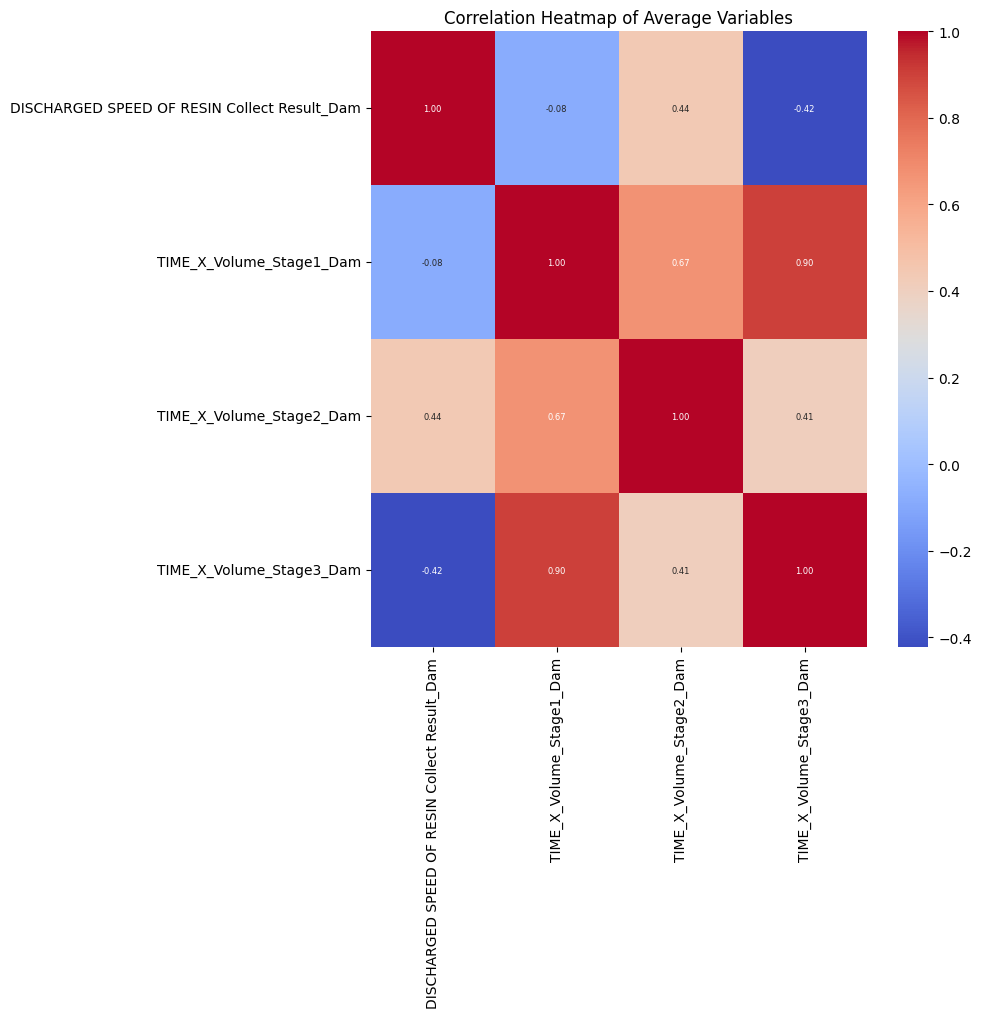

In [151]:
# 상관계수
variables = [
    'DISCHARGED SPEED OF RESIN Collect Result_Dam',
    'TIME_X_Volume_Stage1_Dam',
'TIME_X_Volume_Stage2_Dam',
'TIME_X_Volume_Stage3_Dam'  
]

# Compute the correlation matrix
correlation_matrix = train_data[variables].corr()

# Set the size of the plot
plt.figure(figsize=(8, 8))

# Create a heatmap of the correlation matrix
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", annot_kws={"size": 6})

# Set the title of the heatmap
plt.title("Correlation Heatmap of Average Variables")

# Display the plot
plt.show()

In [152]:
# 삭제할 열 이름 정의
columns_to_drop = [
'DISCHARGED TIME OF RESIN(Stage1) Collect Result_Dam',
'DISCHARGED TIME OF RESIN(Stage2) Collect Result_Dam',
'DISCHARGED TIME OF RESIN(Stage3) Collect Result_Dam',
'Dispense Volume(Stage1) Collect Result_Dam',
'Dispense Volume(Stage2) Collect Result_Dam',
'Dispense Volume(Stage3) Collect Result_Dam',
]

# train_data에서 열 삭제
train_data = train_data.drop(columns=columns_to_drop)

# test_data에서 열 삭제
test_data = test_data.drop(columns=columns_to_drop)

In [153]:
# 'RESIN' 또는 'Dispense Volume'을 포함하는 열 이름 필터링
Process_Desc_col = train_data.filter(regex='RESIN|Dispense Volume').columns

print("\n'RESIN' 또는 'Dispense Volume' 포함 변수>")
for col in Process_Desc_col:
    print(col)


'RESIN' 또는 'Dispense Volume' 포함 변수>
DISCHARGED SPEED OF RESIN Collect Result_Dam
DISCHARGED SPEED OF RESIN Collect Result_Fill1
DISCHARGED TIME OF RESIN(Stage1) Collect Result_Fill1
DISCHARGED TIME OF RESIN(Stage2) Collect Result_Fill1
DISCHARGED TIME OF RESIN(Stage3) Collect Result_Fill1
Dispense Volume(Stage1) Collect Result_Fill1
Dispense Volume(Stage2) Collect Result_Fill1
Dispense Volume(Stage3) Collect Result_Fill1


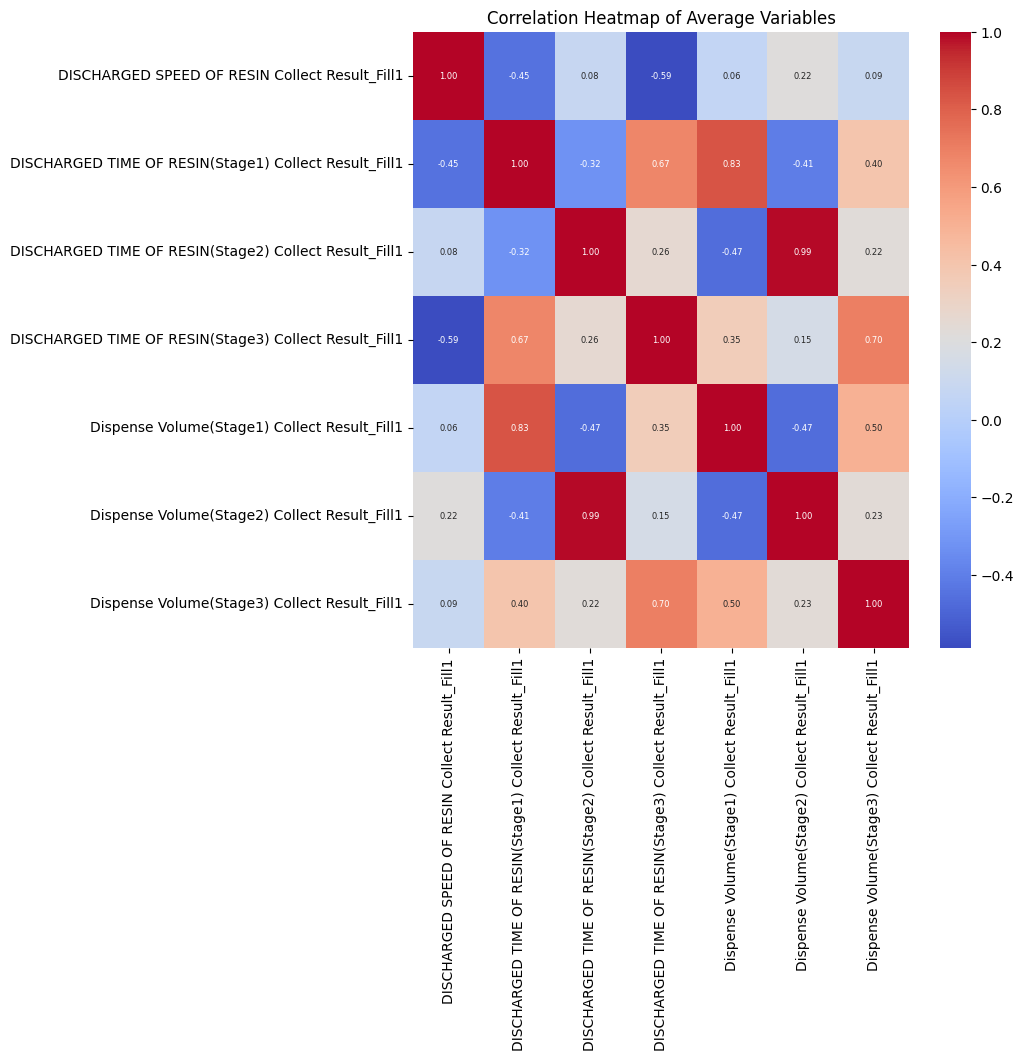

In [154]:
# 상관계수
variables = [
    'DISCHARGED SPEED OF RESIN Collect Result_Fill1',
'DISCHARGED TIME OF RESIN(Stage1) Collect Result_Fill1',
'DISCHARGED TIME OF RESIN(Stage2) Collect Result_Fill1',
'DISCHARGED TIME OF RESIN(Stage3) Collect Result_Fill1',
'Dispense Volume(Stage1) Collect Result_Fill1',
'Dispense Volume(Stage2) Collect Result_Fill1',
'Dispense Volume(Stage3) Collect Result_Fill1',
   
]

# Compute the correlation matrix
correlation_matrix = train_data[variables].corr()

# Set the size of the plot
plt.figure(figsize=(8, 8))

# Create a heatmap of the correlation matrix
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", annot_kws={"size": 6})

# Set the title of the heatmap
plt.title("Correlation Heatmap of Average Variables")

# Display the plot
plt.show()

In [155]:
train_data['TIME_X_Volume_Stage1_Fill1'] = train_data['DISCHARGED TIME OF RESIN(Stage1) Collect Result_Fill1'] * train_data['Dispense Volume(Stage1) Collect Result_Fill1']
train_data['TIME_X_Volume_Stage2_Fill1'] = train_data['DISCHARGED TIME OF RESIN(Stage2) Collect Result_Fill1'] * train_data['Dispense Volume(Stage2) Collect Result_Fill1']
train_data['TIME_X_Volume_Stage3_Fill1'] = train_data['DISCHARGED TIME OF RESIN(Stage3) Collect Result_Fill1'] * train_data['Dispense Volume(Stage3) Collect Result_Fill1']

test_data['TIME_X_Volume_Stage1_Fill1'] = test_data['DISCHARGED TIME OF RESIN(Stage1) Collect Result_Fill1'] * test_data['Dispense Volume(Stage1) Collect Result_Fill1']
test_data['TIME_X_Volume_Stage2_Fill1'] = test_data['DISCHARGED TIME OF RESIN(Stage2) Collect Result_Fill1'] * test_data['Dispense Volume(Stage2) Collect Result_Fill1']
test_data['TIME_X_Volume_Stage3_Fill1'] = test_data['DISCHARGED TIME OF RESIN(Stage3) Collect Result_Fill1'] * test_data['Dispense Volume(Stage3) Collect Result_Fill1']

In [156]:
# 삭제할 열 이름 정의
columns_to_drop = [
'DISCHARGED TIME OF RESIN(Stage1) Collect Result_Fill1',
'DISCHARGED TIME OF RESIN(Stage2) Collect Result_Fill1',
'DISCHARGED TIME OF RESIN(Stage3) Collect Result_Fill1',
'Dispense Volume(Stage1) Collect Result_Fill1',
'Dispense Volume(Stage2) Collect Result_Fill1',
'Dispense Volume(Stage3) Collect Result_Fill1',
]

# train_data에서 열 삭제
train_data = train_data.drop(columns=columns_to_drop)

# test_data에서 열 삭제
test_data = test_data.drop(columns=columns_to_drop)

Distance Speed Collect Result_Dam

In [157]:
# 'Distance Speed Collect Result_Dam'를 포함하는 열 이름 필터링
Process_Desc_col = train_data.filter(like='Distance Speed Collect Result_Dam').columns

print("\n Distance Speed Collect Result_Dam 포함 변수>")
for col in Process_Desc_col:
    print(col)


 Distance Speed Collect Result_Dam 포함 변수>
Stage1 Circle1 Distance Speed Collect Result_Dam
Stage1 Circle2 Distance Speed Collect Result_Dam
Stage1 Circle3 Distance Speed Collect Result_Dam
Stage1 Circle4 Distance Speed Collect Result_Dam
Stage1 Line1 Distance Speed Collect Result_Dam
Stage1 Line2 Distance Speed Collect Result_Dam
Stage1 Line3 Distance Speed Collect Result_Dam
Stage1 Line4 Distance Speed Collect Result_Dam
Stage2 Circle1 Distance Speed Collect Result_Dam
Stage2 Circle2 Distance Speed Collect Result_Dam
Stage2 Circle3 Distance Speed Collect Result_Dam
Stage2 Circle4 Distance Speed Collect Result_Dam
Stage2 Line1 Distance Speed Collect Result_Dam
Stage2 Line2 Distance Speed Collect Result_Dam
Stage2 Line3 Distance Speed Collect Result_Dam
Stage2 Line4 Distance Speed Collect Result_Dam
Stage3 Circle1 Distance Speed Collect Result_Dam
Stage3 Circle2 Distance Speed Collect Result_Dam
Stage3 Circle3 Distance Speed Collect Result_Dam
Stage3 Circle4 Distance Speed Collect Resu

In [158]:
def add_stage_totals(data, stages, suffix='_Distance_Speed_avg_Dam'):
    for stage in stages:
        stage_cols = data.filter(like=stage).columns
        data[f'{stage}{suffix}'] = data[stage_cols].sum(axis=1) / 8

stages = ['Stage1', 'Stage2', 'Stage3']

# train_data에 대해 파생변수 추가
add_stage_totals(train_data, stages)

# test_data에 대해 파생변수 추가
add_stage_totals(test_data, stages)

In [159]:
# 제거할 변수 목록
columns_to_drop = [
'Stage1 Circle1 Distance Speed Collect Result_Dam'
, 'Stage1 Circle2 Distance Speed Collect Result_Dam'
, 'Stage1 Circle3 Distance Speed Collect Result_Dam'
, 'Stage1 Circle4 Distance Speed Collect Result_Dam'
, 'Stage1 Line1 Distance Speed Collect Result_Dam'
, 'Stage1 Line2 Distance Speed Collect Result_Dam'
, 'Stage1 Line3 Distance Speed Collect Result_Dam'
, 'Stage1 Line4 Distance Speed Collect Result_Dam'
, 'Stage2 Circle1 Distance Speed Collect Result_Dam'
, 'Stage2 Circle2 Distance Speed Collect Result_Dam'
, 'Stage2 Circle3 Distance Speed Collect Result_Dam'
, 'Stage2 Circle4 Distance Speed Collect Result_Dam'
, 'Stage2 Line1 Distance Speed Collect Result_Dam'
, 'Stage2 Line2 Distance Speed Collect Result_Dam'
, 'Stage2 Line3 Distance Speed Collect Result_Dam'
, 'Stage2 Line4 Distance Speed Collect Result_Dam'
, 'Stage3 Circle1 Distance Speed Collect Result_Dam'
, 'Stage3 Circle2 Distance Speed Collect Result_Dam'
, 'Stage3 Circle3 Distance Speed Collect Result_Dam'
, 'Stage3 Circle4 Distance Speed Collect Result_Dam'
, 'Stage3 Line1 Distance Speed Collect Result_Dam'
, 'Stage3 Line2 Distance Speed Collect Result_Dam'
, 'Stage3 Line3 Distance Speed Collect Result_Dam'
, 'Stage3 Line4 Distance Speed Collect Result_Dam'
]

# 변수 제거
train_data.drop(columns=columns_to_drop, inplace=True)
test_data.drop(columns=columns_to_drop, inplace=True)

In [160]:
train_data

,Model.Suffix,Workorder,DISCHARGED SPEED OF RESIN Collect Result_Dam,Head Clean Position Z Collect Result_Dam,Head Purge Position Z Collect Result_Dam,Head Zero Position Y Collect Result_Dam,Head Zero Position Z Collect Result_Dam,Machine Tact time Collect Result_Dam,THICKNESS 1 Collect Result_Dam,THICKNESS 2 Collect Result_Dam,...,HEAD NORMAL DISTANCE_TRIANGLE_area_Fill1,TIME_X_Volume_Stage1_Dam,TIME_X_Volume_Stage2_Dam,TIME_X_Volume_Stage3_Dam,TIME_X_Volume_Stage1_Fill1,TIME_X_Volume_Stage2_Fill1,TIME_X_Volume_Stage3_Fill1,Stage1_Distance_Speed_avg_Dam,Stage2_Distance_Speed_avg_Dam,Stage3_Distance_Speed_avg_Dam
0,AJX75334505,4F1XA938-1,16,124.00,130.85,300.0,265.00,58.5,0.000,0.000,...,125.095,15.496,4.872,14.994,153.162,12.312,150.822,5796.082250,5302.148000,5820.727000
1,AJX75334505,3KPM0016-2,10,130.85,130.85,300.0,265.00,65.1,0.000,0.000,...,56.985,31.737,1.666,31.737,173.070,12.312,173.070,4025.600875,9001.747250,4025.600875
2,AJX75334501,4E1X9167-1,16,124.00,130.85,300.0,265.02,76.9,0.012,-0.022,...,264.940,23.667,7.905,23.667,173.070,11.620,170.582,5824.592125,5302.440625,5824.281125
3,AJX75334501,3K1X0057-1,10,130.85,130.85,300.0,265.00,70.5,0.000,0.000,...,162.465,31.737,4.872,31.737,173.070,12.312,173.070,4025.600875,5002.148000,4025.600875
4,AJX75334501,3HPM0007-1,10,133.50,133.50,300.0,265.00,88.3,0.000,0.000,...,45.225,6.499,1.666,14.304,173.070,12.312,173.070,9022.446125,9001.747250,9023.421750
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40501,AJX75334501,3J1XF434-2,10,130.85,130.85,300.0,265.00,56.7,0.000,0.000,...,56.985,20.230,1.750,25.330,173.070,12.312,173.070,5024.162500,9001.757750,5024.800000
40502,AJX75334501,4E1XC796-1,16,124.00,130.85,300.0,265.00,78.5,-0.019,-0.021,...,208.210,15.496,5.015,21.903,173.070,12.312,173.070,5798.570750,5302.165875,5824.371625
40503,AJX75334501,4C1XD438-1,16,124.00,130.85,300.0,265.02,69.5,0.000,0.000,...,159.210,14.058,4.674,14.300,158.025,12.312,158.025,6021.510375,5502.123250,6021.540625
40504,AJX75334501,3I1XA258-1,10,130.85,130.85,300.0,265.00,57.7,0.000,0.000,...,7.710,6.499,1.666,14.453,173.070,12.312,170.582,9022.446125,9001.747250,9023.129375


Thickness

In [161]:
# 'THICKNESS'를 포함하는 열 이름 필터링
Process_Desc_col = train_data.filter(like='THICKNESS').columns

print("\n THICKNESS 포함 변수>")
for col in Process_Desc_col:
    print(col)


 THICKNESS 포함 변수>
THICKNESS 1 Collect Result_Dam
THICKNESS 2 Collect Result_Dam
THICKNESS 3 Collect Result_Dam


In [162]:
# 새로운 파생변수 생성 함수
def create_total_thickness_dam(data):
    data['Total_THICKNESS_Collect_Result_Dam'] = (
        data['THICKNESS 1 Collect Result_Dam']**2 
        + data['THICKNESS 2 Collect Result_Dam']**2 
        + data['THICKNESS 3 Collect Result_Dam']**2
    )
    # 기존 변수 삭제
    data.drop(columns=[
        'THICKNESS 1 Collect Result_Dam',
        'THICKNESS 2 Collect Result_Dam',
        'THICKNESS 3 Collect Result_Dam'
    ], inplace=True)
    return data

train_data = create_total_thickness_dam(train_data)
test_data = create_total_thickness_dam(test_data)

Autoclacve

In [163]:
# 'THICKNESS'를 포함하는 열 이름 필터링
Process_Desc_col = train_data.filter(like='AutoClave').columns

print("\n AutoClave 포함 변수>")
for col in Process_Desc_col:
    print(col)


 AutoClave 포함 변수>
1st Pressure Collect Result_AutoClave
1st Pressure Unit Time_AutoClave
2nd Pressure Collect Result_AutoClave
2nd Pressure Unit Time_AutoClave
3rd Pressure Collect Result_AutoClave
3rd Pressure Unit Time_AutoClave
Chamber Temp. Collect Result_AutoClave
Chamber Temp. Unit Time_AutoClave
Chamber_Temp_OKNG_AutoClave


In [164]:
# 파생변수 생성
train_data['1st_Pressure_x_AutoClave'] = train_data['1st Pressure Collect Result_AutoClave'] * train_data['1st Pressure Unit Time_AutoClave'] 
test_data['1st_Pressure_x_AutoClave'] = test_data['1st Pressure Collect Result_AutoClave'] * test_data['1st Pressure Unit Time_AutoClave'] 

train_data['2nd_Pressure_x_AutoClave'] = train_data['2nd Pressure Collect Result_AutoClave'] * train_data['2nd Pressure Unit Time_AutoClave'] 
test_data['2nd_Pressure_x_AutoClave'] = test_data['2nd Pressure Collect Result_AutoClave'] * test_data['2nd Pressure Unit Time_AutoClave'] 

train_data['3rd_Pressure_x_AutoClave'] = train_data['3rd Pressure Collect Result_AutoClave'] * train_data['3rd Pressure Unit Time_AutoClave'] 
test_data['3rd_Pressure_x_AutoClave'] = test_data['3rd Pressure Collect Result_AutoClave'] * test_data['3rd Pressure Unit Time_AutoClave'] 

train_data['All_Pressure_x_AutoClave'] = train_data['1st_Pressure_x_AutoClave'] + train_data['2nd_Pressure_x_AutoClave'] + train_data['3rd_Pressure_x_AutoClave']
test_data['All_Pressure_x_AutoClave'] = test_data['1st_Pressure_x_AutoClave'] + test_data['2nd_Pressure_x_AutoClave'] + test_data['3rd_Pressure_x_AutoClave']

train_data['All_Pressure_avg_AutoClave'] = train_data['All_Pressure_x_AutoClave'] / train_data['Chamber Temp. Unit Time_AutoClave']
test_data['All_Pressure_avg_AutoClave'] = test_data['All_Pressure_x_AutoClave'] / test_data['Chamber Temp. Unit Time_AutoClave']

train_data['Chamber_Temp_x_AutoClave'] = train_data['Chamber Temp. Collect Result_AutoClave'] * train_data['Chamber Temp. Unit Time_AutoClave']
test_data['Chamber_Temp_x_AutoClave'] = test_data['Chamber Temp. Collect Result_AutoClave'] * test_data['Chamber Temp. Unit Time_AutoClave']

train_data['All_Pressure_frac_Chamber_Temp_AutoClave'] = train_data['All_Pressure_x_AutoClave'] / train_data['Chamber_Temp_x_AutoClave']
test_data['All_Pressure_frac_Chamber_Temp_AutoClave'] = test_data['All_Pressure_x_AutoClave'] / test_data['Chamber_Temp_x_AutoClave']

In [165]:
# '_AutoClave'를 포함하는 열 이름 필터링
Process_Desc_col = train_data.filter(like='_AutoClave').columns

# 필터링된 열 이름 출력
print("<AutoClave 공정 관련 변수>")
for col in Process_Desc_col:
    print(col)

<AutoClave 공정 관련 변수>
1st Pressure Collect Result_AutoClave
1st Pressure Unit Time_AutoClave
2nd Pressure Collect Result_AutoClave
2nd Pressure Unit Time_AutoClave
3rd Pressure Collect Result_AutoClave
3rd Pressure Unit Time_AutoClave
Chamber Temp. Collect Result_AutoClave
Chamber Temp. Unit Time_AutoClave
Chamber_Temp_OKNG_AutoClave
1st_Pressure_x_AutoClave
2nd_Pressure_x_AutoClave
3rd_Pressure_x_AutoClave
All_Pressure_x_AutoClave
All_Pressure_avg_AutoClave
Chamber_Temp_x_AutoClave
All_Pressure_frac_Chamber_Temp_AutoClave


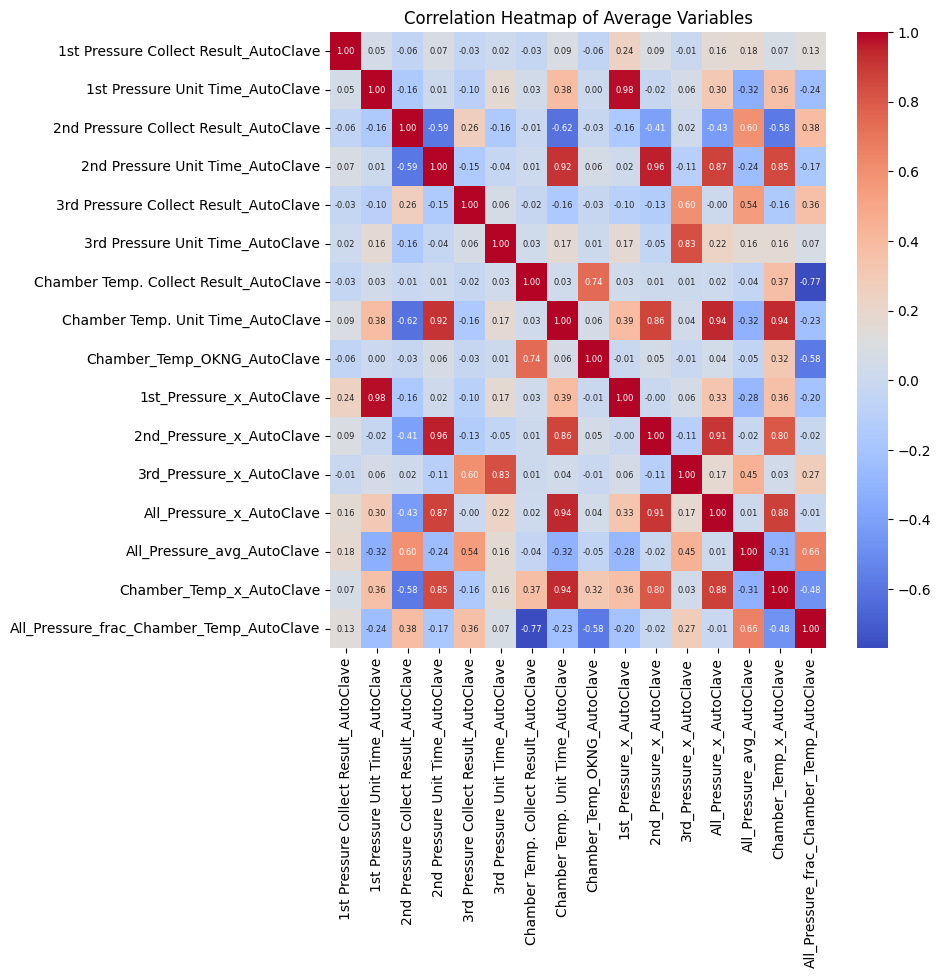

In [166]:
# 상관계수
variables = [
    '1st Pressure Collect Result_AutoClave',
'1st Pressure Unit Time_AutoClave',
'2nd Pressure Collect Result_AutoClave',
'2nd Pressure Unit Time_AutoClave',
'3rd Pressure Collect Result_AutoClave',
'3rd Pressure Unit Time_AutoClave',
'Chamber Temp. Collect Result_AutoClave',
'Chamber Temp. Unit Time_AutoClave',
'Chamber_Temp_OKNG_AutoClave',
'1st_Pressure_x_AutoClave',
'2nd_Pressure_x_AutoClave',
'3rd_Pressure_x_AutoClave',
'All_Pressure_x_AutoClave',
'All_Pressure_avg_AutoClave',
'Chamber_Temp_x_AutoClave',
'All_Pressure_frac_Chamber_Temp_AutoClave'
   
]

# Compute the correlation matrix
correlation_matrix = train_data[variables].corr()

# Set the size of the plot
plt.figure(figsize=(8, 8))

# Create a heatmap of the correlation matrix
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", annot_kws={"size": 6})

# Set the title of the heatmap
plt.title("Correlation Heatmap of Average Variables")

# Display the plot
plt.show()

In [167]:
# 제거할 변수 목록
columns_to_drop = [
'1st Pressure Collect Result_AutoClave',
'1st Pressure Unit Time_AutoClave',
'2nd Pressure Collect Result_AutoClave',
'2nd Pressure Unit Time_AutoClave',
'3rd Pressure Collect Result_AutoClave',
'3rd Pressure Unit Time_AutoClave',
'Chamber Temp. Collect Result_AutoClave',
#'Chamber Temp. Unit Time_AutoClave',
'Chamber_Temp_OKNG_AutoClave',
'All_Pressure_x_AutoClave',
'Chamber_Temp_x_AutoClave'
]

# 변수 제거
train_data.drop(columns=columns_to_drop, inplace=True)
test_data.drop(columns=columns_to_drop, inplace=True)

In [168]:
# '_AutoClave'를 포함하는 열 이름 필터링
Process_Desc_col = train_data.filter(like='_AutoClave').columns

# 필터링된 열 이름 출력
print("<AutoClave 공정 관련 변수>")
for col in Process_Desc_col:
    print(col)

<AutoClave 공정 관련 변수>
Chamber Temp. Unit Time_AutoClave
1st_Pressure_x_AutoClave
2nd_Pressure_x_AutoClave
3rd_Pressure_x_AutoClave
All_Pressure_avg_AutoClave
All_Pressure_frac_Chamber_Temp_AutoClave


In [169]:
# 타겟 변수를 0과 1로 변환
train_data['target_binary'] = train_data['target'].apply(lambda x: 1 if x == 'AbNormal' else 0)

# Workorder 변수의 값에 대한 타겟 변수 비율 계산
workorder_target_ratio = train_data.groupby('Workorder')['target_binary'].mean()

# 파생 변수 생성 함수
def create_derived_variable(row, ratio_dict, threshold):
    return 1 if ratio_dict.get(row['Workorder'], 0) >= threshold else 0

# 파생 변수 생성
train_data['Workorder_0.9'] = train_data.apply(create_derived_variable, axis=1, ratio_dict=workorder_target_ratio, threshold=0.9)
train_data['Workorder_0.7'] = train_data.apply(create_derived_variable, axis=1, ratio_dict=workorder_target_ratio, threshold=0.7)
train_data['Workorder_0.5'] = train_data.apply(create_derived_variable, axis=1, ratio_dict=workorder_target_ratio, threshold=0.5)

test_data['Workorder_0.9'] = test_data.apply(create_derived_variable, axis=1, ratio_dict=workorder_target_ratio, threshold=0.9)
test_data['Workorder_0.7'] = test_data.apply(create_derived_variable, axis=1, ratio_dict=workorder_target_ratio, threshold=0.7)
test_data['Workorder_0.5'] = test_data.apply(create_derived_variable, axis=1, ratio_dict=workorder_target_ratio, threshold=0.5)


# 불필요한 변수 제거
train_data.drop(['target_binary'], axis=1, inplace=True)

In [170]:
### 총시간 대비 비율 변수
def calculate_total_time_and_ratios(data):
    data['total_time'] = (
        data['Machine Tact time Collect Result_Dam'] +
        data['Machine Tact time Collect Result_Fill1'] +
        data['Machine Tact time Collect Result_Fill2'] +
        data['Chamber Temp. Unit Time_AutoClave']
    )
    data['time_ratio_Dam'] = (data['Machine Tact time Collect Result_Dam'] / data['total_time']).round(3)
    data['time_ratio_Fill1'] = (data['Machine Tact time Collect Result_Fill1'] / data['total_time']).round(3)
    data['time_ratio_Fill2'] = (data['Machine Tact time Collect Result_Fill2'] / data['total_time']).round(3)
    data['time_ratio_AutoClave'] = (data['Chamber Temp. Unit Time_AutoClave'] / data['total_time']).round(3)
    return data

# train_data와 test_data에 함수 적용
train_data = calculate_total_time_and_ratios(train_data)
test_data = calculate_total_time_and_ratios(test_data)

In [171]:
# 변수 제거
train_data.drop(columns=[
    'total_time'
    , 'Machine Tact time Collect Result_Dam'
    , 'Machine Tact time Collect Result_Fill1'
    , 'Machine Tact time Collect Result_Fill2'
    , 'Chamber Temp. Unit Time_AutoClave'], inplace=True)

test_data.drop(columns=[
    'total_time'
    , 'Machine Tact time Collect Result_Dam'
    , 'Machine Tact time Collect Result_Fill1'
    , 'Machine Tact time Collect Result_Fill2'
    , 'Chamber Temp. Unit Time_AutoClave'], inplace=True)

In [172]:
train_data.info()
print('---')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40506 entries, 0 to 40505
Data columns (total 50 columns):
 #   Column                                          Non-Null Count  Dtype  
---  ------                                          --------------  -----  
 0   Model.Suffix                                    40506 non-null  object 
 1   Workorder                                       40506 non-null  object 
 2   DISCHARGED SPEED OF RESIN Collect Result_Dam    40506 non-null  int64  
 3   Head Clean Position Z Collect Result_Dam        40506 non-null  float64
 4   Head Purge Position Z Collect Result_Dam        40506 non-null  float64
 5   Head Zero Position Y Collect Result_Dam         40506 non-null  float64
 6   Head Zero Position Z Collect Result_Dam         40506 non-null  float64
 7   WorkMode Collect Result                         40506 non-null  float64
 8   DISCHARGED SPEED OF RESIN Collect Result_Fill1  40506 non-null  float64
 9   Head Purge Position Z Collect Result_Fi

In [173]:
# 각 변수별로 결측값이 존재하는지 확인하는 코드
missing_values = train_data.isnull().sum()

# 결측값이 존재하는 변수와 그 개수 출력
missing_values = missing_values[missing_values > 0]
print(missing_values)

# 결측값이 존재하는 변수명을 리스트에 담기
missing_columns = missing_values.index.tolist()
# print("결측값이 존재하는 변수명:", missing_columns)

Series([], dtype: int64)


타겟 인코딩

In [174]:
# 'target' 열의 변수 타입을 object로 변경
# -> test 데이터는 float64 타입으로 되어있음 
test_data['target'] = test_data['target'].astype('object')

# object 타입의 변수 출력
train_object_columns = train_data.select_dtypes(include=['object']).columns
test_object_columns = test_data.select_dtypes(include=['object']).columns

print(train_object_columns, f" train_object_columns 갯수 : {len(train_object_columns)}")
print(test_object_columns, f" test_object_columns 갯수 : {len(test_object_columns)}")

# 각 object 변수의 고유 값 개수 출력
print("\nTrain Data:")
for col in train_object_columns:
    unique_count = train_data[col].nunique()
    print(f"{col} unique 값 갯수: {unique_count}")

print("\nTest Data:")
for col in test_object_columns:
    unique_count = test_data[col].nunique()
    print(f"{col} unique 값 갯수: {unique_count}")

Index(['Model.Suffix', 'Workorder', 'target'], dtype='object')  train_object_columns 갯수 : 3
Index(['Set ID', 'Model.Suffix', 'Workorder', 'target'], dtype='object')  test_object_columns 갯수 : 4

Train Data:
Model.Suffix unique 값 갯수: 7
Workorder unique 값 갯수: 663
target unique 값 갯수: 2

Test Data:
Set ID unique 값 갯수: 17361
Model.Suffix unique 값 갯수: 7
Workorder unique 값 갯수: 662
target unique 값 갯수: 0


In [175]:
import category_encoders as ce


In [176]:
train_data

,Model.Suffix,Workorder,DISCHARGED SPEED OF RESIN Collect Result_Dam,Head Clean Position Z Collect Result_Dam,Head Purge Position Z Collect Result_Dam,Head Zero Position Y Collect Result_Dam,Head Zero Position Z Collect Result_Dam,WorkMode Collect Result,DISCHARGED SPEED OF RESIN Collect Result_Fill1,Head Purge Position Z Collect Result_Fill1,...,3rd_Pressure_x_AutoClave,All_Pressure_avg_AutoClave,All_Pressure_frac_Chamber_Temp_AutoClave,Workorder_0.9,Workorder_0.7,Workorder_0.5,time_ratio_Dam,time_ratio_Fill1,time_ratio_Fill2,time_ratio_AutoClave
0,AJX75334505,4F1XA938-1,16,124.00,130.85,300.0,265.00,0.0,10.6,128,...,59.880,0.374662,0.006938,0,0,0,0.118,0.113,0.040,0.729
1,AJX75334505,3KPM0016-2,10,130.85,130.85,300.0,265.00,1.0,10.6,145,...,60.258,0.357847,0.006627,0,0,0,0.104,0.091,0.031,0.774
2,AJX75334501,4E1X9167-1,16,124.00,130.85,300.0,265.02,0.0,10.6,128,...,60.258,0.376482,0.006723,0,0,0,0.148,0.113,0.038,0.700
3,AJX75334501,3K1X0057-1,10,130.85,130.85,300.0,265.00,1.0,10.6,145,...,60.500,0.349605,0.006474,0,0,0,0.112,0.091,0.032,0.765
4,AJX75334501,3HPM0007-1,10,133.50,133.50,300.0,265.00,1.0,10.6,85,...,59.760,0.351000,0.007468,0,0,0,0.130,0.133,0.029,0.708
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40501,AJX75334501,3J1XF434-2,10,130.85,130.85,300.0,265.00,1.0,10.6,145,...,60.500,0.350104,0.006483,0,0,0,0.093,0.085,0.031,0.791
40502,AJX75334501,4E1XC796-1,16,124.00,130.85,300.0,265.00,0.0,10.6,128,...,59.760,0.369676,0.007544,0,0,0,0.151,0.113,0.040,0.696
40503,AJX75334501,4C1XD438-1,16,124.00,130.85,300.0,265.02,0.0,10.6,128,...,60.258,0.372499,0.007760,0,0,0,0.137,0.111,0.039,0.714
40504,AJX75334501,3I1XA258-1,10,130.85,130.85,300.0,265.00,1.0,10.6,145,...,60.379,0.351602,0.006511,0,0,0,0.093,0.093,0.033,0.781


In [177]:
# 타겟 변수와 범주형 변수 지정
## Target Encoding의 smoothing 파라미터는 default로 auto로 설정되어 있음
target = 'target'  # 타겟 변수 이름으로 변경
categorical_columns = [
    'Model.Suffix',
    'Workorder',
]  # 범주형 변수 이름으로 변경

# 타겟 값을 숫자로 변환
target_mapping = {'Normal': 0, 'AbNormal': 1}
train_data[target] = train_data[target].map(target_mapping)
test_data[target] = test_data[target].map(target_mapping)

# 열이 존재하는지 확인
missing_columns = [col for col in categorical_columns if col not in train_data.columns]
if missing_columns:
    raise ValueError(f"train_data에 다음 열이 존재하지 않습니다: {missing_columns}")

# 타겟 인코더 생성 및 학습
encoder = ce.TargetEncoder(cols=categorical_columns)
train_data = encoder.fit_transform(train_data, train_data[target])

# Set ID 열을 별도로 저장
set_id = test_data['Set ID']

# 테스트 데이터 인코딩 (Set ID 열 제외)
test_data = test_data.drop(columns=['Set ID'])
test_data = encoder.transform(test_data)

# Set ID 열을 맨 앞에 추가
test_data.insert(0, 'Set ID', set_id)

# categorical_columns에 해당하는 열의 데이터 값만 확인
print(train_data[categorical_columns].head(3))
print(test_data[categorical_columns].head(3))

# 역 매핑 딕셔너리 생성
reverse_target_mapping = {v: k for k, v in target_mapping.items()}

# 타겟 값을 원래대로 변환
train_data[target] = train_data[target].map(reverse_target_mapping)
test_data[target] = test_data[target].map(reverse_target_mapping)

print("--- train_data ---")

# 변환된 타겟 값 확인
print(train_data[[target]].value_counts())

   Model.Suffix  Workorder
0      0.049336   0.158385
1      0.049336   0.015314
2      0.056712   0.009534
   Model.Suffix  Workorder
0      0.056712   0.091912
1      0.056712   0.024247
2      0.056712   0.091463
--- train_data ---
target  
Normal      38156
AbNormal     2350
Name: count, dtype: int64


데이터 분할

In [178]:
# 데이터셋 분할
x_train, x_val, y_train, y_val = train_test_split(
    train_data.drop("target", axis=1),
    train_data["target"],
    test_size=0.2,
    shuffle=True,
    random_state=RANDOM_STATE,
)

In [179]:
df_train, df_val = train_test_split(
    train_data,
    test_size=0.2,
    stratify=train_data["target"],
    random_state=RANDOM_STATE,
)

def print_stats(df: pd.DataFrame):
    num_normal = len(df[df["target"] == "Normal"])
    num_abnormal = len(df[df["target"] == "AbNormal"])

    print(f"  Total: Normal: {num_normal}, AbNormal: {num_abnormal}" + f" ratio: {num_abnormal/num_normal}")


# Print statistics
print(f"  \tAbnormal\tNormal")
print_stats(df_train)
print_stats(df_val)

  	Abnormal	Normal
  Total: Normal: 30524, AbNormal: 1880 ratio: 0.06159087930808544
  Total: Normal: 7632, AbNormal: 470 ratio: 0.061582809224318656


In [180]:
com_variables = [
    'Model.Suffix'
    , 'Workorder'
    , 'WorkMode Collect Result'
    , 'Dispenser_1'
    , 'Dispenser_2'
    , 'Receip_No_Collect_Result'
    , 'PalletID_Collect_Result'
    , 'Production_Qty_Collect_Result'
    , 'Judge_Value_OK'
    , 'Workorder_0.9'
    , 'Workorder_0.7'
    , 'Workorder_0.5'
]

# 변수들로만 이루어진 DataFrame 생성
filtered_data = train_data[com_variables]

In [181]:
# 상관계수 행렬 계산
correlation_matrix = filtered_data.corr()

# 자기자신을 제외하고 특정 값 이상인 조합 찾기
strong_correlations = correlation_matrix[(correlation_matrix >= 0.7) & (correlation_matrix != 1)]

# 리스트로 변환
strong_correlations_pairs = strong_correlations.stack().reset_index()
strong_correlations_pairs.columns = ['Variable 1', 'Variable 2', 'Correlation']

# 결과 출력
strong_correlations_pairs = strong_correlations_pairs[strong_correlations_pairs['Correlation'] >= 0.7]
print(strong_correlations_pairs)

                Variable 1               Variable 2  Correlation
0              Dispenser_2  PalletID_Collect_Result     0.860274
1  PalletID_Collect_Result              Dispenser_2     0.860274
2            Workorder_0.9            Workorder_0.7     0.747407
3            Workorder_0.7            Workorder_0.9     0.747407
4            Workorder_0.7            Workorder_0.5     0.816325
5            Workorder_0.5            Workorder_0.7     0.816325


In [182]:
# 열 삭제
train_data.drop(['Workorder_0.7', 'PalletID_Collect_Result'], axis=1, inplace=True)
test_data.drop(['Workorder_0.7', 'PalletID_Collect_Result'], axis=1, inplace=True)

In [183]:
# 공통 변수 리스트
com_variables_train = [
    'target'
    , 'Model.Suffix'
    , 'Workorder'
    , 'WorkMode Collect Result'
    , 'Dispenser_1'
    , 'Dispenser_2'
    , 'Receip_No_Collect_Result'
    # , 'PalletID_Collect_Result'
    , 'Production_Qty_Collect_Result'
    , 'Judge_Value_OK'
    , 'Workorder_0.9'
    # , 'Workorder_0.7'
    , 'Workorder_0.5'
]

com_variables_test = [
    'target'
    , 'Set ID'
    , 'Model.Suffix'
    , 'Workorder'
    , 'WorkMode Collect Result'
    , 'Dispenser_1'
    , 'Dispenser_2'
    , 'Receip_No_Collect_Result'
    # , 'PalletID_Collect_Result'
    , 'Production_Qty_Collect_Result'
    , 'Judge_Value_OK'
    , 'Workorder_0.9'
    # , 'Workorder_0.7'
    , 'Workorder_0.5'
]

In [184]:
# 열 이름 필터링
Process_Desc_col = train_data.filter(like='_Dam').columns

# 필터링된 열 이름 출력
print("<Dam 공정 관련 변수>")
for col in Process_Desc_col:
    print(col)

<Dam 공정 관련 변수>
DISCHARGED SPEED OF RESIN Collect Result_Dam
Head Clean Position Z Collect Result_Dam
Head Purge Position Z Collect Result_Dam
Head Zero Position Y Collect Result_Dam
Head Zero Position Z Collect Result_Dam
CURE_Time_Dam
HEAD NORMAL DISTANCE_STAGE1_STAGE2_Dam
HEAD NORMAL DISTANCE_STAGE1_STAGE3_Dam
HEAD NORMAL DISTANCE_TRIANGLE_area_Dam
HEAD NORMAL DISTANCE_TRIANGLE_height_Dam
TIME_X_Volume_Stage1_Dam
TIME_X_Volume_Stage2_Dam
TIME_X_Volume_Stage3_Dam
Stage1_Distance_Speed_avg_Dam
Stage2_Distance_Speed_avg_Dam
Stage3_Distance_Speed_avg_Dam
Total_THICKNESS_Collect_Result_Dam
time_ratio_Dam


In [186]:
# 새로운 변수 목록
variables = [
    "DISCHARGED SPEED OF RESIN Collect Result_Dam",
    #"DISCHARGED TIME OF RESIN(Stage1) Collect Result_Dam",
    # "DISCHARGED TIME OF RESIN(Stage2) Collect Result_Dam",
    # "DISCHARGED TIME OF RESIN(Stage3) Collect Result_Dam",
    #"Dispense Volume(Stage1) Collect Result_Dam",
    #"Dispense Volume(Stage2) Collect Result_Dam",
    # "Dispense Volume(Stage3) Collect Result_Dam",
    "Head Clean Position Z Collect Result_Dam",
    "Head Purge Position Z Collect Result_Dam",
    "Head Zero Position Y Collect Result_Dam",
    # "Head Zero Position Z Collect Result_Dam",
    "CURE_Time_Dam",
    "HEAD NORMAL DISTANCE_STAGE1_STAGE3_Dam",
    # "HEAD NORMAL DISTANCE_TRIANGLE_area_Dam",
    "HEAD NORMAL DISTANCE_TRIANGLE_height_Dam",
    "Stage1_Distance_Speed_avg_Dam",
    "Stage2_Distance_Speed_avg_Dam",
    # "Stage3_Distance_Speed_avg_Dam",
    "Total_THICKNESS_Collect_Result_Dam",
    "time_ratio_Dam",
    'TIME_X_Volume_Stage1_Dam',
    'TIME_X_Volume_Stage2_Dam',
    'TIME_X_Volume_Stage3_Dam',
]

# 변수들로만 이루어진 DataFrame 생성
filtered_data = train_data[variables]
filtered_data = test_data[variables]

In [187]:
# 드랍할 열 목록
columns_to_drop = [
    "DISCHARGED TIME OF RESIN(Stage1) Collect Result_Dam",
    "DISCHARGED TIME OF RESIN(Stage2) Collect Result_Dam",
    "DISCHARGED TIME OF RESIN(Stage3) Collect Result_Dam",
    "Dispense Volume(Stage1) Collect Result_Dam",
    "Dispense Volume(Stage2) Collect Result_Dam",
    "Dispense Volume(Stage3) Collect Result_Dam",
    "Head Zero Position Z Collect Result_Dam",
    "HEAD NORMAL DISTANCE_TRIANGLE_area_Dam",
    "Stage3_Distance_Speed_avg_Dam"
]

# 열 삭제
train_data.drop(columns=columns_to_drop, inplace=True, errors='ignore')
test_data.drop(columns=columns_to_drop, inplace=True, errors='ignore')

In [188]:
# 열 이름 필터링
Process_Desc_col = train_data.filter(like='_AutoClave').columns

# 필터링된 열 이름 출력
print("<AutoClave 공정 관련 변수>")
for col in Process_Desc_col:
    print(col)

<AutoClave 공정 관련 변수>
1st_Pressure_x_AutoClave
2nd_Pressure_x_AutoClave
3rd_Pressure_x_AutoClave
All_Pressure_avg_AutoClave
All_Pressure_frac_Chamber_Temp_AutoClave
time_ratio_AutoClave


In [189]:
# 새로운 변수 목록
variables = [
    #"1st Pressure Collect Result_AutoClave",
    #"2nd Pressure Collect Result_AutoClave",
    #"3rd Pressure Collect Result_AutoClave",
    #"Chamber Temp. Collect Result_AutoClave",
    #"Chamber_Temp_OKNG_AutoClave",
    "1st_Pressure_x_AutoClave",
    "2nd_Pressure_x_AutoClave",
    "3rd_Pressure_x_AutoClave",
    "All_Pressure_avg_AutoClave",
    #"Chamber_Temp_x_AutoClave",
    "All_Pressure_frac_Chamber_Temp_AutoClave",
    "time_ratio_AutoClave"
]

# 변수들로만 이루어진 DataFrame 생성
filtered_data = train_data[variables]
filtered_data = test_data[variables]

In [190]:
# 드랍할 열 목록
columns_to_drop = [
    "1st Pressure Collect Result_AutoClave",
    "2nd Pressure Collect Result_AutoClave",
    "3rd Pressure Collect Result_AutoClave",
    "Chamber Temp. Collect Result_AutoClave",
    "Chamber_Temp_OKNG_AutoClave",
    "Chamber_Temp_x_AutoClave"
]

# 열 삭제
train_data.drop(columns=columns_to_drop, inplace=True, errors='ignore')
test_data.drop(columns=columns_to_drop, inplace=True, errors='ignore')

In [191]:
# 열 이름 필터링
Process_Desc_col = train_data.filter(like='_Fill1').columns

# 필터링된 열 이름 출력
print("<Fill1 공정 관련 변수>")
for col in Process_Desc_col:
    print(col)

<Fill1 공정 관련 변수>
DISCHARGED SPEED OF RESIN Collect Result_Fill1
Head Purge Position Z Collect Result_Fill1
HEAD NORMAL DISTANCE_STAGE1_STAGE2_Fill1
HEAD NORMAL DISTANCE_STAGE2_STAGE3_Fill1
HEAD NORMAL DISTANCE_STAGE1_STAGE3_Fill1
HEAD NORMAL DISTANCE_TRIANGLE_area_Fill1
TIME_X_Volume_Stage1_Fill1
TIME_X_Volume_Stage2_Fill1
TIME_X_Volume_Stage3_Fill1
time_ratio_Fill1


In [193]:
# 새로운 변수 목록
variables = [
    "DISCHARGED SPEED OF RESIN Collect Result_Fill1",
    #"DISCHARGED TIME OF RESIN(Stage1) Collect Result_Fill1",
    #"DISCHARGED TIME OF RESIN(Stage2) Collect Result_Fill1",
    #"DISCHARGED TIME OF RESIN(Stage3) Collect Result_Fill1",
    # "Dispense Volume(Stage1) Collect Result_Fill1",
    # "Dispense Volume(Stage2) Collect Result_Fill1",
    #"Dispense Volume(Stage3) Collect Result_Fill1",
    "Head Purge Position Z Collect Result_Fill1",
    'HEAD NORMAL DISTANCE_STAGE1_STAGE2_Fill1',
    'HEAD NORMAL DISTANCE_STAGE2_STAGE3_Fill1',
    "HEAD NORMAL DISTANCE_STAGE1_STAGE3_Fill1",
    "HEAD NORMAL DISTANCE_TRIANGLE_area_Fill1",
    #"HEAD NORMAL DISTANCE_TRIANGLE_height_Fill1",
    'TIME_X_Volume_Stage1_Fill1',
    'TIME_X_Volume_Stage2_Fill1',
    'TIME_X_Volume_Stage3_Fill1',
    "time_ratio_Fill1"
]

# 변수들로만 이루어진 DataFrame 생성
filtered_data = train_data[variables]
filtered_data = test_data[variables]

In [194]:

# 드랍할 열 목록
columns_to_drop = [
    "HEAD NORMAL DISTANCE_TRIANGLE_height_Fill1",
    "DISCHARGED TIME OF RESIN(Stage1) Collect Result_Fill1",
    "DISCHARGED TIME OF RESIN(Stage2) Collect Result_Fill1",
    "DISCHARGED TIME OF RESIN(Stage3) Collect Result_Fill1",
    "Dispense Volume(Stage1) Collect Result_Fill1",
    "Dispense Volume(Stage2) Collect Result_Fill1",
    "Dispense Volume(Stage3) Collect Result_Fill1"
]

# 열 삭제
train_data.drop(columns=columns_to_drop, inplace=True, errors='ignore')
test_data.drop(columns=columns_to_drop, inplace=True, errors='ignore')

In [195]:
# 열 이름 필터링
Process_Desc_col = train_data.filter(like='_Fill2').columns

# 필터링된 열 이름 출력
print("<Fill1 공정 관련 변수>")
for col in Process_Desc_col:
    print(col)

<Fill1 공정 관련 변수>
Head Purge Position Z Collect Result_Fill2
CURE_Time_Fill2
time_ratio_Fill2


In [196]:
# 새로운 변수 목록
variables = [
    'Head Purge Position Z Collect Result_Fill2',
    'CURE_Time_Fill2',
    'time_ratio_Fill2'
]

# 변수들로만 이루어진 DataFrame 생성
filtered_data = train_data[variables]

In [198]:
### dam 데이터셋
# 열 이름 필터링 후 공통 변수와 결합
Process_Desc_col = train_data.filter(like='_Dam').columns

# train
final_columns_train = list(Process_Desc_col) + com_variables_train
train_data_dam = train_data[final_columns_train]

# test 
final_columns_test = list(Process_Desc_col) + com_variables_test
test_data_dam = test_data[final_columns_test]

In [199]:
### fill1 데이터셋
# 열 이름 필터링 후 공통 변수와 결합
Process_Desc_col = train_data.filter(like='_Fill1').columns

# train
final_columns_train = list(Process_Desc_col) + com_variables_train
train_data_fill1 = train_data[final_columns_train]

# test 
final_columns_test = list(Process_Desc_col) + com_variables_test
test_data_fill1 = test_data[final_columns_test]

In [200]:
### fill2 데이터셋
# 열 이름 필터링 후 공통 변수와 결합
Process_Desc_col = train_data.filter(like='_Fill2').columns

# train
final_columns_train = list(Process_Desc_col) + com_variables_train
train_data_fill2 = train_data[final_columns_train]

# test 
final_columns_test = list(Process_Desc_col) + com_variables_test
test_data_fill2 = test_data[final_columns_test]

In [201]:
### autoclave 데이터셋
# 열 이름 필터링 후 공통 변수와 결합
Process_Desc_col = train_data.filter(like='_AutoClave').columns

# train
final_columns_train = list(Process_Desc_col) + com_variables_train
train_data_autoclave = train_data[final_columns_train]

# test 
final_columns_test = list(Process_Desc_col) + com_variables_test
test_data_autoclave = test_data[final_columns_test]

In [206]:
train_data_dam.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40506 entries, 0 to 40505
Data columns (total 26 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   DISCHARGED SPEED OF RESIN Collect Result_Dam  40506 non-null  int64  
 1   Head Clean Position Z Collect Result_Dam      40506 non-null  float64
 2   Head Purge Position Z Collect Result_Dam      40506 non-null  float64
 3   Head Zero Position Y Collect Result_Dam       40506 non-null  float64
 4   CURE_Time_Dam                                 40506 non-null  float64
 5   HEAD NORMAL DISTANCE_STAGE1_STAGE2_Dam        40506 non-null  float64
 6   HEAD NORMAL DISTANCE_STAGE1_STAGE3_Dam        40506 non-null  float64
 7   HEAD NORMAL DISTANCE_TRIANGLE_height_Dam      40506 non-null  float64
 8   TIME_X_Volume_Stage1_Dam                      40506 non-null  float64
 9   TIME_X_Volume_Stage2_Dam                      40506 non-null 

In [207]:
def get_clf_eval(y_test, y_pred_proba, threshold=0.5):
    # 확률을 기준으로 예측 레이블 생성
    y_pred = (y_pred_proba >= threshold).astype(int)  # 0.5 이상의 확률을 양성으로 간주

    confusion = confusion_matrix(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    print("Confusion Matrix:\n", confusion)
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")

In [209]:
from lightgbm import LGBMClassifier

In [210]:
model_Dam = LGBMClassifier(
    n_estimators=1019
    , num_leaves=1513
    , max_depth=115
    , learning_rate=0.010329666890588058
    , min_child_samples=7
    , verbose = -1
    , boosting= 'dart'
    , random_state=RANDOM_STATE
    # , class_weight=class_weights
)
model_AutoClave = LGBMClassifier(
    n_estimators=1019
    , num_leaves=1513
    , max_depth=115
    , learning_rate=0.010329666890588058
    , min_child_samples=7
    , verbose = -1
    , boosting= 'dart'
    , random_state=RANDOM_STATE
    # , class_weight=class_weights
)
model_Fill1 = LGBMClassifier(
    n_estimators=1019
    , num_leaves=1513
    , max_depth=115
    , learning_rate=0.010329666890588058
    , min_child_samples=7
    , verbose = -1
    , boosting= 'dart'
    , random_state=RANDOM_STATE
    # , class_weight=class_weights
)
model_Fill2 = LGBMClassifier(
    n_estimators=1019
    , num_leaves=1513
    , max_depth=115
    , learning_rate=0.010329666890588058
    , min_child_samples=7
    , verbose = -1
    , boosting= 'dart'
    , random_state=RANDOM_STATE
    # , class_weight=class_weights
)

In [211]:
df_train_dam, df_val_dam = train_test_split(
    train_data_dam,
    test_size=0.2,
    stratify=train_data["target"],
    random_state=RANDOM_STATE,
)
df_train_fill1, df_val_fill1 = train_test_split(
    train_data_fill1,
    test_size=0.2,
    stratify=train_data["target"],
    random_state=RANDOM_STATE,
)
df_train_fill2, df_val_fill2 = train_test_split(
    train_data_fill2,
    test_size=0.2,
    stratify=train_data["target"],
    random_state=RANDOM_STATE,
)
df_train_autoclave, df_val_autoclave = train_test_split(
    train_data_autoclave,
    test_size=0.2,
    stratify=train_data["target"],
    random_state=RANDOM_STATE,
)

In [212]:
# df_train_dam 데이터로 학습
df_train_dam["target"] = df_train_dam["target"].apply(lambda x: 1 if x == 'AbNormal' else 0)

# features = df_train.columns.tolist()

train_x = df_train_dam.drop(columns=["target"])
train_y = df_train_dam["target"]

model_Dam.fit(train_x, train_y)

LGBMClassifier(boosting='dart', learning_rate=0.010329666890588058,
               max_depth=115, min_child_samples=7, n_estimators=1019,
               num_leaves=1513, random_state=110, verbose=-1)

In [213]:
# df_train_fill1 데이터로 학습
df_train_fill1["target"] = df_train_fill1["target"].apply(lambda x: 1 if x == 'AbNormal' else 0)

# features = df_train.columns.tolist()

train_x = df_train_fill1.drop(columns=["target"])
train_y = df_train_fill1["target"]

model_Fill1.fit(train_x, train_y)

LGBMClassifier(boosting='dart', learning_rate=0.010329666890588058,
               max_depth=115, min_child_samples=7, n_estimators=1019,
               num_leaves=1513, random_state=110, verbose=-1)

In [214]:
# df_train_fill2 데이터로 학습
df_train_fill2["target"] = df_train_fill2["target"].apply(lambda x: 1 if x == 'AbNormal' else 0)

# features = df_train.columns.tolist()

train_x = df_train_fill2.drop(columns=["target"])
train_y = df_train_fill2["target"]

model_Fill2.fit(train_x, train_y)

LGBMClassifier(boosting='dart', learning_rate=0.010329666890588058,
               max_depth=115, min_child_samples=7, n_estimators=1019,
               num_leaves=1513, random_state=110, verbose=-1)

In [215]:
# train_data_autoclave 데이터로 학습
train_data_autoclave["target"] = train_data_autoclave["target"].apply(lambda x: 1 if x == 'AbNormal' else 0)

train_x_all_autoclave = train_data_autoclave.drop(columns=["target"])
train_y_all_autoclave = train_data_autoclave["target"]

model_AutoClave.fit(train_x_all_autoclave, train_y_all_autoclave)

C:\Users\KimDongyoung\AppData\Local\Temp\ipykernel_19836\4007190017.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data_autoclave["target"] = train_data_autoclave["target"].apply(lambda x: 1 if x == 'AbNormal' else 0)


LGBMClassifier(boosting='dart', learning_rate=0.010329666890588058,
               max_depth=115, min_child_samples=7, n_estimators=1019,
               num_leaves=1513, random_state=110, verbose=-1)

In [216]:
# 예측에 필요한 데이터 분리
x_test_dam = test_data_dam.drop(["target", "Set ID"], axis=1)
x_test_fill1 = test_data_fill1.drop(["target", "Set ID"], axis=1)
x_test_fill2 = test_data_fill2.drop(["target", "Set ID"], axis=1)
x_test_autoclave = test_data_autoclave.drop(["target", "Set ID"], axis=1)

# 테스트 데이터에 대한 예측 확률
probs_dam = model_Dam.predict_proba(x_test_dam)[:, 1]
probs_fill1 = model_Fill1.predict_proba(x_test_fill1)[:, 1]
probs_fill2 = model_Fill2.predict_proba(x_test_fill2)[:, 1]
probs_autoclave = model_AutoClave.predict_proba(x_test_autoclave)[:, 1]

In [217]:
# 스레스 홀드 설정
threshold = 0.3

# 예측 확률과 스레스 홀드 비교하여 1 또는 0 부여
preds_dam = (probs_dam > threshold).astype(int)
preds_fill1 = (probs_fill1 > threshold).astype(int)
preds_fill2 = (probs_fill2 > threshold).astype(int)
preds_autoclave = (probs_autoclave > threshold).astype(int)

# 하나라도 스레스 홀드보다 높은 경우 1 부여
all_preds = (preds_dam | preds_fill1 | preds_fill2 | preds_autoclave).astype(int)

# 테스트 데이터에서 AbNormal로 예측된 개수 출력
print(sum(all_preds))

1766


In [218]:
# 스레스 홀드 설정
threshold = 0.25

# 예측 확률과 스레스 홀드 비교하여 1 또는 0 부여
preds_dam = (probs_dam > threshold).astype(int)
preds_fill1 = (probs_fill1 > threshold).astype(int)
preds_fill2 = (probs_fill2 > threshold).astype(int)
preds_autoclave = (probs_autoclave > threshold).astype(int)

# 하나라도 스레스 홀드보다 높은 경우 1 부여
all_preds = (preds_dam | preds_fill1 | preds_fill2 | preds_autoclave).astype(int)

# 테스트 데이터에서 AbNormal로 예측된 개수 출력
print(sum(all_preds))

2344


In [223]:
# 스레스 홀드 설정
threshold = 0.35

# 예측 확률과 스레스 홀드 비교하여 1 또는 0 부여
preds_dam = (probs_dam > threshold).astype(int)
preds_fill1 = (probs_fill1 > threshold).astype(int)
preds_fill2 = (probs_fill2 > threshold).astype(int)
preds_autoclave = (probs_autoclave > threshold).astype(int)

# 하나라도 스레스 홀드보다 높은 경우 1 부여
all_preds = (preds_dam | preds_fill1 | preds_fill2 | preds_autoclave).astype(int)

# 테스트 데이터에서 AbNormal로 예측된 개수 출력
print(sum(all_preds))

1373


### 제출하기

In [224]:
# 제출 데이터 읽어오기 (df_test는 전처리된 데이터가 저장됨)
df_sub = pd.read_csv("C:/Users/KimDongyoung/Desktop/git_LGaimers5/Lg_aimers5/data/submission.csv")
df_sub["target"] = all_preds

# df_sub['target'] 값을 문자열 레이블로 변환
df_sub['target'] = df_sub['target'].apply(lambda x: 'AbNormal' if x == 1 else 'Normal')

# 제출 파일 저장
df_sub.to_csv("submission0815.csv", index=False)